In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm
import collections
%matplotlib inline

In [44]:
import catboost

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import operator

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def generate_simple_dataset(linspace, chanals, pandas=False):
    p1,p2,p3 = linspace
    v = np.linspace(p1, p2, p3)
    
    dataset = v
    for i in range(chanals-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*2*pi*t) + 5*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def func_for_2class(t, noise=0.5):
    return 3*np.cos(5*2*pi*t) + 2*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def func_for_3class(t, noise=0.5):
    return 4*np.cos(5*2*pi*t) + 10*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def func_general(t, noise=0.5):
    return 9*np.cos(5*2*pi*t) + 10*np.cos(15*2*pi*t) + 3*np.cos(20*2*pi*t) + np.random.normal(0,1)

def get_cosinus_matrix(chanals, linspace):
    data_simple = generate_simple_dataset(linspace, chanals)
    vec = data_simple[0]
    
    size = (chanals, linspace[2])
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    

    data_simple = func_general(data_simple)
    data_simple[0] = data_simple[1]
    
    data_simple[65] = vec
    data_simple[10] = vec
    data_simple[100] = vec
    #data_simple[60] = vec
    #data_simple[61] = vec
    #data_simple[20] = vec

    
    return data_simple

In [6]:
CHANALS = 128
LINSPACE = 0, 200, 20000
N_COMPONENTS_PCA = 60

matrix = get_cosinus_matrix(chanals=CHANALS, linspace=LINSPACE)
size = matrix.shape
class_ = size[1]//3

In [7]:
class_

6666

In [8]:
matrix.shape

(128, 20000)

In [9]:
(matrix[65][::2][::2][::2])

array([ 9.03019197, -3.47086194, -3.47441376, ..., -8.13240658,
        4.44990308,  6.18625289])

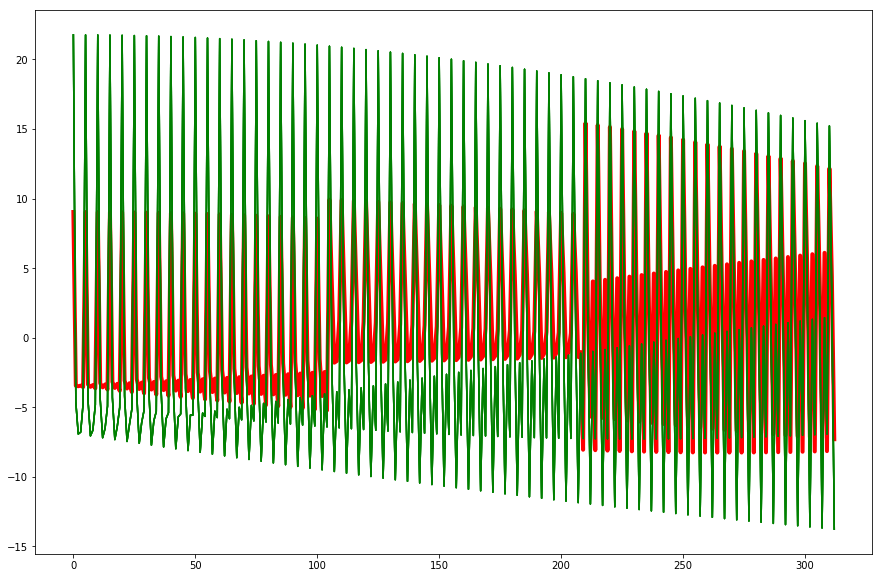

In [10]:
plt.figure(figsize=(15,10))
plt.plot(matrix[65][::2][::2][::2][::2][::2][::2], c='r', linewidth=4.0)
plt.plot(matrix[0][::2][::2][::2][::2][::2][::2], c='g')
plt.plot(matrix[10][::2][::2][::2][::2][::2][::2], c='r')
plt.plot(matrix[1][::2][::2][::2][::2][::2][::2], c='g')
plt.plot(matrix[2][::2][::2][::2][::2][::2][::2], c='g')
plt.plot(matrix[3][::2][::2][::2][::2][::2][::2], c='g')

plt.show()

In [11]:
from sklearn.decomposition import FastICA

FastICA = FastICA(n_components=128).fit(matrix.T)
ICA = FastICA.transform(matrix.T)


In [12]:
FastICA.mixing_.shape

(128, 128)

In [13]:
matrix = ICA.T

In [14]:
# CHANALS = 100
# size = matrix.shape

In [15]:
matrix.shape

(128, 20000)

In [16]:
class_

6666

In [17]:
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:matrix.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1, sample_size=300, step=100)
sample_calss2 = get_sample(matrix_calss2, sample_size=300, step=100)
sample_calss3 = get_sample(matrix_calss3, sample_size=300, step=100)


In [18]:
len(sample_calss1)

67

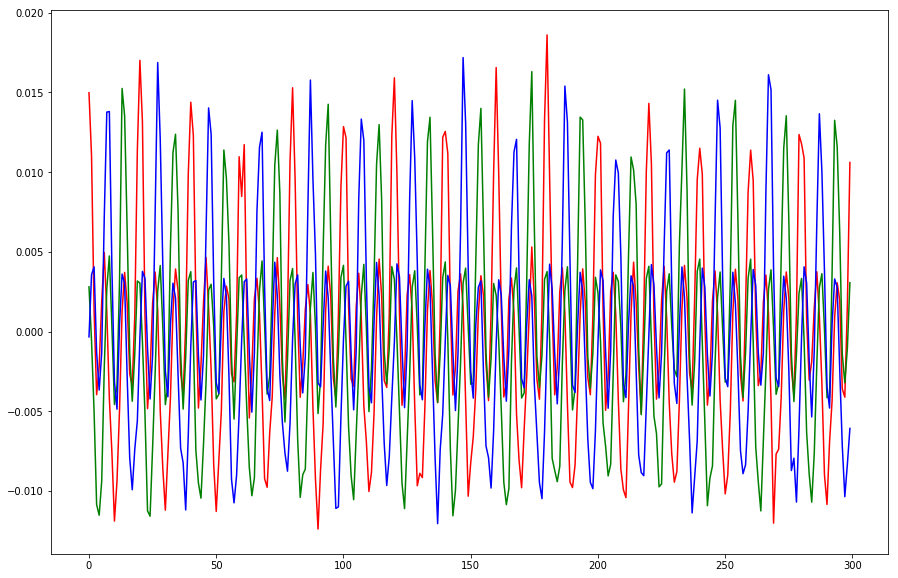

In [19]:
plt.figure(figsize=(15,10))
plt.plot(sample_calss1[0][100], c='r')
plt.plot(sample_calss2[0][100], c='g')
plt.plot(sample_calss3[0][100], c='b')
# plt.plot(sample_calss1[0][2], c='b')
# plt.plot(sample_calss2[0][2], c='b')
#plt.plot(sample_calss1[0][3], c='b')

plt.show()

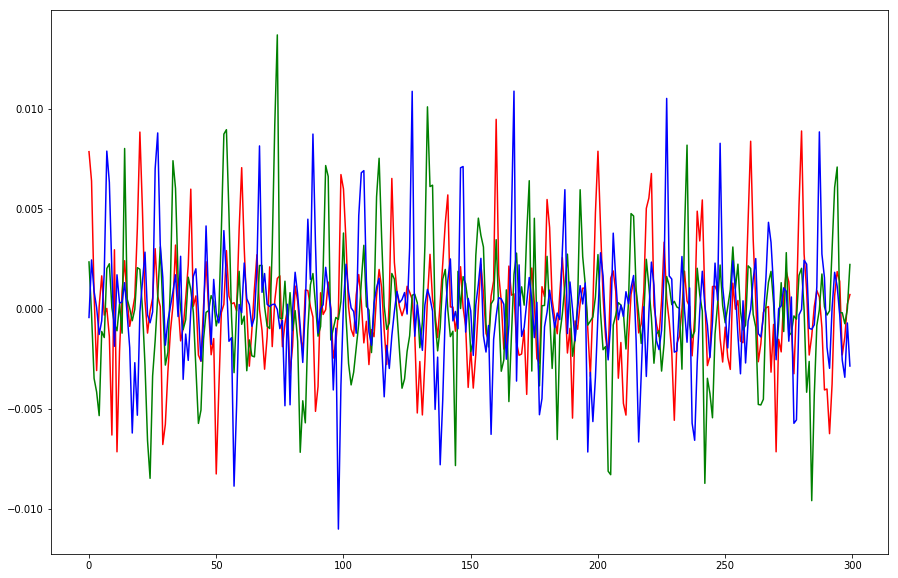

In [20]:
plt.figure(figsize=(15,10))
plt.plot(sample_calss1[0][1], c='r')
plt.plot(sample_calss2[0][1], c='g')
plt.plot(sample_calss3[0][1], c='b')
# plt.plot(sample_calss1[0][2], c='b')
# plt.plot(sample_calss2[0][2], c='b')
#plt.plot(sample_calss1[0][3], c='b')

plt.show()

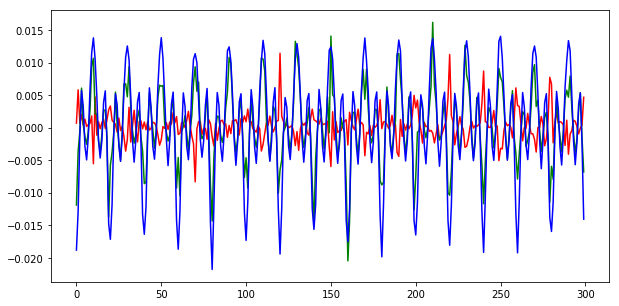

In [21]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][2], c='r')
plt.plot(sample_calss1[10][3], c='g')
plt.plot(sample_calss1[10][4], c='b')
plt.show()

In [22]:
i_ = 0
for i in range(len(sample_calss1)):
    for j in range(sample_calss1[0].shape[0]):
        #print(sample_calss1[i][j].shape[0])
        if sample_calss1[i][j].shape[0] != 300:
            if i_ == 0:
                i_ = i

In [23]:
sample_calss1 = sample_calss1[:i_]
sample_calss2 = sample_calss2[:i_]
sample_calss3 = sample_calss3[:i_]

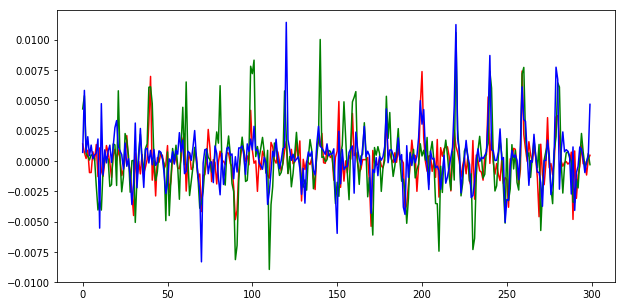

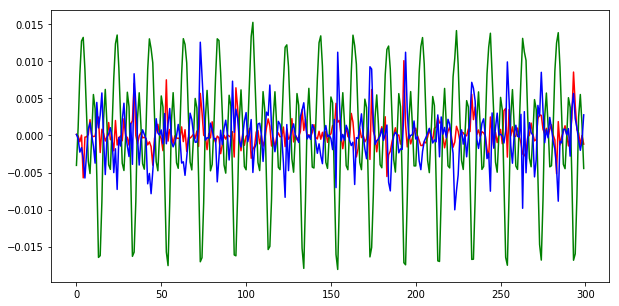

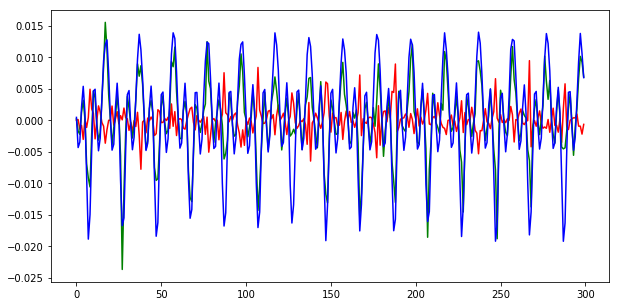

In [24]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1[10][10], c='r')
plt.plot(sample_calss1[10][1], c='g')
plt.plot(sample_calss1[10][2], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2[10][10], c='r')
plt.plot(sample_calss2[10][4], c='g')
plt.plot(sample_calss2[10][0], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3[10][10], c='r')
plt.plot(sample_calss3[10][3], c='g')
plt.plot(sample_calss3[10][4], c='b')
plt.show()

In [25]:
samples_fft = list(fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3, freq=100))


In [26]:
len_class = len(sample_calss1)
sample_calss1_fft = samples_fft[:len_class]
sample_calss2_fft = samples_fft[len_class:len_class*2]
sample_calss3_fft = samples_fft[len_class*2:]

In [27]:
FIRST_N_FFT = len(sample_calss1_fft[0][0])

In [28]:
FIRST_N_FFT

174

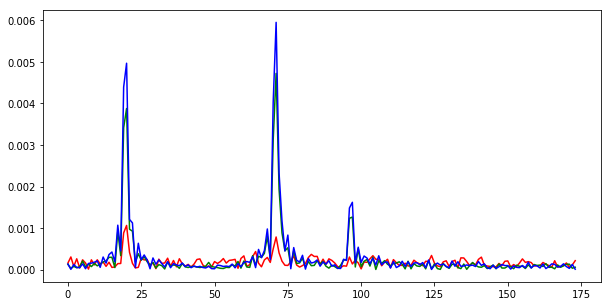

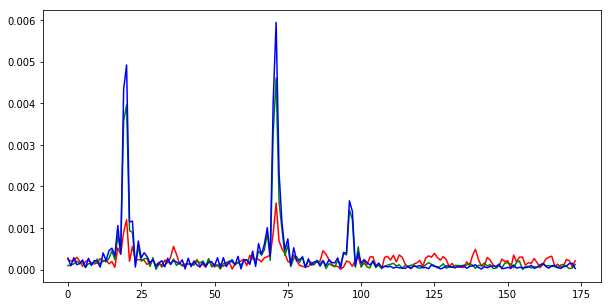

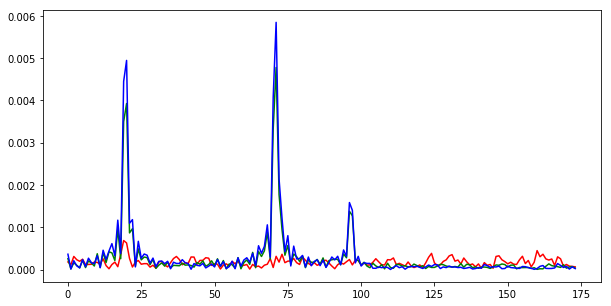

In [29]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft[10][65], c='r')
plt.plot(sample_calss1_fft[10][64], c='g')
plt.plot(sample_calss1_fft[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft[10][65], c='r')
plt.plot(sample_calss2_fft[10][64], c='g')
plt.plot(sample_calss2_fft[10][63], c='b')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft[10][65], c='r')
plt.plot(sample_calss3_fft[10][64], c='g')
plt.plot(sample_calss3_fft[10][63], c='b')
plt.show()

In [30]:
for i in range(len(sample_calss1_fft)):
    for j in range(sample_calss1_fft[0].shape[0]):
        sh = sample_calss1_fft[i][j].shape[0]
        if sh != FIRST_N_FFT:
            print(sh)

In [31]:
#Создание строк для датасета, из матрицы 128*174 -> в вектор 22272
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

In [32]:
(sample_calss1_fft[0].shape)

(128, 174)

In [33]:
def values_65(samples_fft):
    strings = []
    for i in range(len(samples_fft)):
        new_string = []
        for n in range(samples_fft[i].shape[1]):
            new_string.append(samples_fft[i][65,n])
        strings.append(new_string)

    return strings


In [34]:
def index_65(sample_calss_fft_str, sample_calss_fft_str_65):
    indexes = []
    for i in range(len(sample_calss1_fft_str)):
        index = []
        for j in range(len(sample_calss_fft_str_65[i])):
            index.append(sample_calss_fft_str[i].index(sample_calss_fft_str_65[i][j]))
        indexes.append(index)
    return indexes

In [35]:
sample_calss_1_fft_str_65 = values_65(sample_calss1_fft)
sample_calss_2_fft_str_65 = values_65(sample_calss2_fft)
sample_calss_3_fft_str_65 = values_65(sample_calss3_fft)


sample_calss_1_fft_str_65_index = index_65(sample_calss1_fft_str, sample_calss_1_fft_str_65)
sample_calss_2_fft_str_65_index = index_65(sample_calss2_fft_str, sample_calss_2_fft_str_65)
sample_calss_3_fft_str_65_index = index_65(sample_calss3_fft_str, sample_calss_3_fft_str_65)
    


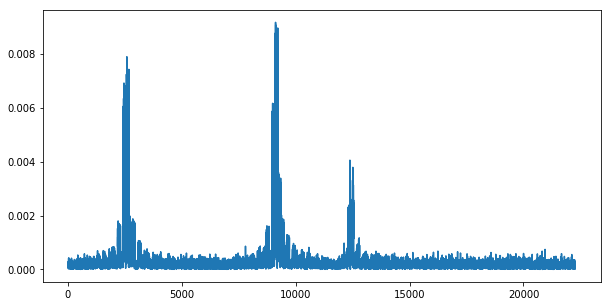

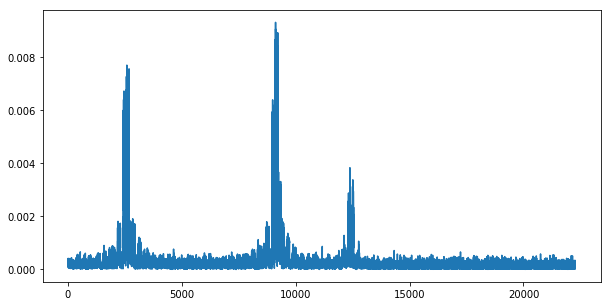

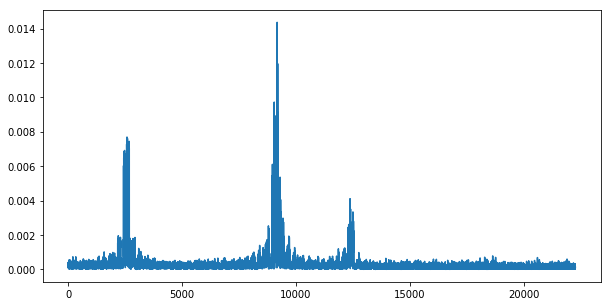

In [36]:
plt.figure(figsize=(10,5))
plt.plot(sample_calss1_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss2_fft_str[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sample_calss3_fft_str[0])
plt.show()

In [37]:
size[0]

128

In [38]:
#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_1['label'] = 1

data_class_1 = np.array(data_class_1)

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_2['label'] = 2

data_class_2 = np.array(data_class_2)

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class, size[0] * 174)))
data_class_3['label'] = 3

data_class_3 = np.array(data_class_3)

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3[i, :-1] = sample_calss3_fft_str[i]
    

    

data = np.vstack([data_class_1, data_class_2, data_class_3])
data = pd.DataFrame(data)
print(data.shape)

100%|██████████| 64/64 [00:00<00:00, 760.37it/s]


(192, 22273)


In [39]:
data.columns = [*data.columns[:-1], 'label']

In [40]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    
    features_good = [i for i in features_good if i not in ['[', ']', ',']]
    features_normal = [i for i in features_normal if i not in ['[', ']', ',']]
    features_bad = [i for i in features_bad if i not in ['[', ']', ',']]
    
    features_good = list(map(lambda x: str(x), features_good))
    features_normal = list(map(lambda x: str(x), features_normal))
    features_bad = list(map(lambda x: str(x), features_bad))
    
    
    return features_good, features_normal, features_bad

In [41]:
'''
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}
'''

"\n{'bootstrap': True,\n 'max_depth': 10,\n 'max_features': 'auto',\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'n_estimators': 200}\n"

In [42]:

# ###SOLO

# ## Понизим размерность до 60 компонент
# from sklearn.decomposition import PCA
# PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
# #Стандартизируем матрицу
# # Scaler = StandardScaler()
# # data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# data_standart = (data).iloc[:, :-1]
# # Понижаем размерность
# data_pca = PCA.fit_transform(data_standart)
# data_pca = pd.DataFrame(data_pca)

# # data_pca['label'] = data['label'].values
# labels = data['label'].values

# #Посмотрим важные признаки с помощью RF
# # rf = RandomForestClassifier(bootstrap=True, max_depth=10,
# #                            max_features='auto', min_samples_leaf=1,
# #                            min_samples_split=2, n_estimators=200)
# rf = RandomForestClassifier(n_estimators=10000)
# rf.fit(data_pca, labels)

# feature_importances = pd.DataFrame(rf.feature_importances_,
#                                index = data_pca.columns,
#                                 columns=['importance']).sort_values('importance',ascending=False)

# features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [45]:

### ANSAMBEL


## Понизим размерность до 60 компонент
from sklearn.decomposition import PCA
PCA = PCA(n_components=N_COMPONENTS_PCA, random_state=100)
#Стандартизируем матрицу
# Scaler = StandardScaler()
# data_standart = Scaler.fit_transform((data).iloc[:, :-1])
data_standart = (data).iloc[:, :-1]

# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values


fg = []
fn = []
fb = []
for _ in range(20):
    cat = catboost.CatBoostClassifier()
    cat.fit(data_pca, labels)
    feature_importances = pd.DataFrame(cat.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    
    features_good, features_normal, features_bad = scoring_fi(feature_importances)
    fg.extend(features_good)
    fn.extend(features_normal)
    fb.extend(features_bad)

features_good = list(map(lambda x: x[0], sorted(collections.Counter(fg).items(), key=operator.itemgetter(1), reverse=True)[:10]))
features_normal = list(map(lambda x: x[0],
                           sorted(collections.Counter(fn).items(), key=operator.itemgetter(1), reverse=True)))

features_normal = list(set(features_normal) - set(features_good))

features_bad = list(set(fb) - set(features_good) - set(features_normal))

Learning rate set to 0.07274
0:	learn: 1.0256125	total: 67.9ms	remaining: 1m 7s
1:	learn: 0.9790898	total: 76.3ms	remaining: 38.1s
2:	learn: 0.9216771	total: 84.7ms	remaining: 28.2s
3:	learn: 0.8739367	total: 93.2ms	remaining: 23.2s
4:	learn: 0.8324629	total: 102ms	remaining: 20.2s
5:	learn: 0.7793582	total: 110ms	remaining: 18.2s
6:	learn: 0.7330389	total: 118ms	remaining: 16.8s
7:	learn: 0.6843242	total: 127ms	remaining: 15.7s
8:	learn: 0.6496527	total: 135ms	remaining: 14.9s
9:	learn: 0.6085908	total: 143ms	remaining: 14.2s
10:	learn: 0.5858065	total: 152ms	remaining: 13.7s
11:	learn: 0.5479938	total: 160ms	remaining: 13.2s
12:	learn: 0.5255129	total: 168ms	remaining: 12.8s
13:	learn: 0.5007244	total: 176ms	remaining: 12.4s
14:	learn: 0.4800805	total: 184ms	remaining: 12.1s
15:	learn: 0.4480366	total: 191ms	remaining: 11.8s
16:	learn: 0.4244719	total: 199ms	remaining: 11.5s
17:	learn: 0.4075010	total: 207ms	remaining: 11.3s
18:	learn: 0.3917883	total: 215ms	remaining: 11.1s
19:	lear

163:	learn: 0.0225310	total: 1.39s	remaining: 7.11s
164:	learn: 0.0223900	total: 1.4s	remaining: 7.1s
165:	learn: 0.0222136	total: 1.41s	remaining: 7.09s
166:	learn: 0.0219958	total: 1.42s	remaining: 7.08s
167:	learn: 0.0217520	total: 1.43s	remaining: 7.07s
168:	learn: 0.0215770	total: 1.44s	remaining: 7.06s
169:	learn: 0.0213431	total: 1.44s	remaining: 7.05s
170:	learn: 0.0211907	total: 1.45s	remaining: 7.03s
171:	learn: 0.0210302	total: 1.46s	remaining: 7.02s
172:	learn: 0.0208605	total: 1.47s	remaining: 7.01s
173:	learn: 0.0204019	total: 1.47s	remaining: 6.97s
174:	learn: 0.0200489	total: 1.48s	remaining: 6.95s
175:	learn: 0.0196242	total: 1.48s	remaining: 6.92s
176:	learn: 0.0194941	total: 1.49s	remaining: 6.91s
177:	learn: 0.0194080	total: 1.49s	remaining: 6.9s
178:	learn: 0.0192645	total: 1.5s	remaining: 6.89s
179:	learn: 0.0191587	total: 1.51s	remaining: 6.88s
180:	learn: 0.0189986	total: 1.52s	remaining: 6.87s
181:	learn: 0.0188051	total: 1.53s	remaining: 6.86s
182:	learn: 0.01

332:	learn: 0.0061374	total: 2.39s	remaining: 4.78s
333:	learn: 0.0060909	total: 2.39s	remaining: 4.76s
334:	learn: 0.0060452	total: 2.39s	remaining: 4.75s
335:	learn: 0.0060085	total: 2.4s	remaining: 4.74s
336:	learn: 0.0059640	total: 2.4s	remaining: 4.72s
337:	learn: 0.0059203	total: 2.4s	remaining: 4.71s
338:	learn: 0.0058772	total: 2.41s	remaining: 4.69s
339:	learn: 0.0058669	total: 2.42s	remaining: 4.69s
340:	learn: 0.0058539	total: 2.42s	remaining: 4.68s
341:	learn: 0.0058280	total: 2.43s	remaining: 4.67s
342:	learn: 0.0057862	total: 2.43s	remaining: 4.66s
343:	learn: 0.0057450	total: 2.43s	remaining: 4.64s
344:	learn: 0.0057275	total: 2.44s	remaining: 4.63s
345:	learn: 0.0057171	total: 2.45s	remaining: 4.63s
346:	learn: 0.0056769	total: 2.45s	remaining: 4.62s
347:	learn: 0.0056373	total: 2.45s	remaining: 4.6s
348:	learn: 0.0056130	total: 2.46s	remaining: 4.59s
349:	learn: 0.0055743	total: 2.46s	remaining: 4.57s
350:	learn: 0.0055361	total: 2.46s	remaining: 4.55s
351:	learn: 0.00

507:	learn: 0.0028884	total: 2.96s	remaining: 2.86s
508:	learn: 0.0028784	total: 2.96s	remaining: 2.85s
509:	learn: 0.0028685	total: 2.96s	remaining: 2.85s
510:	learn: 0.0028587	total: 2.96s	remaining: 2.84s
511:	learn: 0.0028560	total: 2.97s	remaining: 2.83s
512:	learn: 0.0028513	total: 2.98s	remaining: 2.83s
513:	learn: 0.0028416	total: 2.98s	remaining: 2.82s
514:	learn: 0.0028319	total: 2.98s	remaining: 2.81s
515:	learn: 0.0028224	total: 2.99s	remaining: 2.8s
516:	learn: 0.0028128	total: 2.99s	remaining: 2.79s
517:	learn: 0.0028094	total: 3s	remaining: 2.79s
518:	learn: 0.0028000	total: 3s	remaining: 2.78s
519:	learn: 0.0027907	total: 3s	remaining: 2.77s
520:	learn: 0.0027860	total: 3.01s	remaining: 2.76s
521:	learn: 0.0027767	total: 3.01s	remaining: 2.75s
522:	learn: 0.0027721	total: 3.02s	remaining: 2.75s
523:	learn: 0.0027629	total: 3.02s	remaining: 2.74s
524:	learn: 0.0027538	total: 3.02s	remaining: 2.73s
525:	learn: 0.0027447	total: 3.02s	remaining: 2.72s
526:	learn: 0.0027357	

684:	learn: 0.0019061	total: 3.53s	remaining: 1.62s
685:	learn: 0.0019018	total: 3.53s	remaining: 1.62s
686:	learn: 0.0019002	total: 3.54s	remaining: 1.61s
687:	learn: 0.0018959	total: 3.54s	remaining: 1.61s
688:	learn: 0.0018917	total: 3.54s	remaining: 1.6s
689:	learn: 0.0018874	total: 3.55s	remaining: 1.59s
690:	learn: 0.0018832	total: 3.55s	remaining: 1.59s
691:	learn: 0.0018818	total: 3.56s	remaining: 1.58s
692:	learn: 0.0018776	total: 3.56s	remaining: 1.58s
693:	learn: 0.0018735	total: 3.56s	remaining: 1.57s
694:	learn: 0.0018720	total: 3.57s	remaining: 1.56s
695:	learn: 0.0018705	total: 3.58s	remaining: 1.56s
696:	learn: 0.0018683	total: 3.58s	remaining: 1.56s
697:	learn: 0.0018645	total: 3.59s	remaining: 1.55s
698:	learn: 0.0018604	total: 3.59s	remaining: 1.54s
699:	learn: 0.0018563	total: 3.59s	remaining: 1.54s
700:	learn: 0.0018523	total: 3.59s	remaining: 1.53s
701:	learn: 0.0018482	total: 3.59s	remaining: 1.52s
702:	learn: 0.0018442	total: 3.6s	remaining: 1.52s
703:	learn: 0.

895:	learn: 0.0013674	total: 4.3s	remaining: 500ms
896:	learn: 0.0013652	total: 4.31s	remaining: 495ms
897:	learn: 0.0013643	total: 4.31s	remaining: 490ms
898:	learn: 0.0013622	total: 4.32s	remaining: 485ms
899:	learn: 0.0013600	total: 4.32s	remaining: 480ms
900:	learn: 0.0013578	total: 4.32s	remaining: 475ms
901:	learn: 0.0013557	total: 4.33s	remaining: 470ms
902:	learn: 0.0013535	total: 4.33s	remaining: 465ms
903:	learn: 0.0013514	total: 4.33s	remaining: 460ms
904:	learn: 0.0013508	total: 4.34s	remaining: 456ms
905:	learn: 0.0013487	total: 4.34s	remaining: 450ms
906:	learn: 0.0013479	total: 4.35s	remaining: 446ms
907:	learn: 0.0013472	total: 4.36s	remaining: 442ms
908:	learn: 0.0013450	total: 4.36s	remaining: 437ms
909:	learn: 0.0013429	total: 4.36s	remaining: 431ms
910:	learn: 0.0013408	total: 4.36s	remaining: 426ms
911:	learn: 0.0013387	total: 4.37s	remaining: 421ms
912:	learn: 0.0013366	total: 4.37s	remaining: 416ms
913:	learn: 0.0013345	total: 4.37s	remaining: 411ms
914:	learn: 0

67:	learn: 0.0881715	total: 516ms	remaining: 7.07s
68:	learn: 0.0854738	total: 525ms	remaining: 7.08s
69:	learn: 0.0834988	total: 533ms	remaining: 7.08s
70:	learn: 0.0820782	total: 542ms	remaining: 7.08s
71:	learn: 0.0799347	total: 550ms	remaining: 7.09s
72:	learn: 0.0786852	total: 558ms	remaining: 7.08s
73:	learn: 0.0771880	total: 565ms	remaining: 7.07s
74:	learn: 0.0757041	total: 572ms	remaining: 7.06s
75:	learn: 0.0746290	total: 580ms	remaining: 7.05s
76:	learn: 0.0729234	total: 587ms	remaining: 7.04s
77:	learn: 0.0718230	total: 594ms	remaining: 7.03s
78:	learn: 0.0705830	total: 602ms	remaining: 7.02s
79:	learn: 0.0697427	total: 609ms	remaining: 7.01s
80:	learn: 0.0689190	total: 617ms	remaining: 7s
81:	learn: 0.0677697	total: 624ms	remaining: 6.99s
82:	learn: 0.0666569	total: 632ms	remaining: 6.98s
83:	learn: 0.0657886	total: 639ms	remaining: 6.97s
84:	learn: 0.0646704	total: 647ms	remaining: 6.96s
85:	learn: 0.0637005	total: 654ms	remaining: 6.95s
86:	learn: 0.0628260	total: 662ms	

258:	learn: 0.0099354	total: 1.91s	remaining: 5.46s
259:	learn: 0.0098638	total: 1.91s	remaining: 5.45s
260:	learn: 0.0097467	total: 1.92s	remaining: 5.43s
261:	learn: 0.0097100	total: 1.92s	remaining: 5.42s
262:	learn: 0.0095955	total: 1.93s	remaining: 5.4s
263:	learn: 0.0095699	total: 1.94s	remaining: 5.42s
264:	learn: 0.0095247	total: 1.96s	remaining: 5.43s
265:	learn: 0.0094144	total: 1.96s	remaining: 5.41s
266:	learn: 0.0093065	total: 1.96s	remaining: 5.39s
267:	learn: 0.0092011	total: 1.97s	remaining: 5.37s
268:	learn: 0.0091761	total: 1.98s	remaining: 5.37s
269:	learn: 0.0090735	total: 1.98s	remaining: 5.35s
270:	learn: 0.0089733	total: 1.98s	remaining: 5.33s
271:	learn: 0.0089358	total: 1.99s	remaining: 5.33s
272:	learn: 0.0088384	total: 1.99s	remaining: 5.31s
273:	learn: 0.0087432	total: 2s	remaining: 5.29s
274:	learn: 0.0086500	total: 2s	remaining: 5.27s
275:	learn: 0.0085588	total: 2s	remaining: 5.25s
276:	learn: 0.0085273	total: 2.01s	remaining: 5.24s
277:	learn: 0.0085032	

427:	learn: 0.0038253	total: 2.68s	remaining: 3.59s
428:	learn: 0.0038203	total: 2.69s	remaining: 3.58s
429:	learn: 0.0038026	total: 2.69s	remaining: 3.57s
430:	learn: 0.0037851	total: 2.7s	remaining: 3.56s
431:	learn: 0.0037678	total: 2.7s	remaining: 3.55s
432:	learn: 0.0037506	total: 2.7s	remaining: 3.54s
433:	learn: 0.0037445	total: 2.71s	remaining: 3.53s
434:	learn: 0.0037276	total: 2.71s	remaining: 3.52s
435:	learn: 0.0037108	total: 2.71s	remaining: 3.51s
436:	learn: 0.0036941	total: 2.72s	remaining: 3.5s
437:	learn: 0.0036776	total: 2.72s	remaining: 3.49s
438:	learn: 0.0036613	total: 2.72s	remaining: 3.48s
439:	learn: 0.0036451	total: 2.72s	remaining: 3.46s
440:	learn: 0.0036291	total: 2.72s	remaining: 3.45s
441:	learn: 0.0036132	total: 2.73s	remaining: 3.44s
442:	learn: 0.0036087	total: 2.73s	remaining: 3.44s
443:	learn: 0.0035930	total: 2.73s	remaining: 3.42s
444:	learn: 0.0035774	total: 2.74s	remaining: 3.41s
445:	learn: 0.0035730	total: 2.74s	remaining: 3.41s
446:	learn: 0.00

598:	learn: 0.0022781	total: 3.26s	remaining: 2.18s
599:	learn: 0.0022754	total: 3.27s	remaining: 2.18s
600:	learn: 0.0022719	total: 3.28s	remaining: 2.18s
601:	learn: 0.0022701	total: 3.3s	remaining: 2.18s
602:	learn: 0.0022639	total: 3.3s	remaining: 2.17s
603:	learn: 0.0022579	total: 3.3s	remaining: 2.16s
604:	learn: 0.0022518	total: 3.3s	remaining: 2.16s
605:	learn: 0.0022458	total: 3.31s	remaining: 2.15s
606:	learn: 0.0022398	total: 3.31s	remaining: 2.14s
607:	learn: 0.0022339	total: 3.31s	remaining: 2.13s
608:	learn: 0.0022310	total: 3.32s	remaining: 2.13s
609:	learn: 0.0022290	total: 3.33s	remaining: 2.13s
610:	learn: 0.0022236	total: 3.34s	remaining: 2.12s
611:	learn: 0.0022177	total: 3.34s	remaining: 2.12s
612:	learn: 0.0022119	total: 3.34s	remaining: 2.11s
613:	learn: 0.0022061	total: 3.35s	remaining: 2.1s
614:	learn: 0.0022003	total: 3.35s	remaining: 2.1s
615:	learn: 0.0021981	total: 3.36s	remaining: 2.09s
616:	learn: 0.0021924	total: 3.36s	remaining: 2.08s
617:	learn: 0.0021

798:	learn: 0.0015734	total: 4.04s	remaining: 1.01s
799:	learn: 0.0015725	total: 4.05s	remaining: 1.01s
800:	learn: 0.0015696	total: 4.05s	remaining: 1s
801:	learn: 0.0015670	total: 4.05s	remaining: 1s
802:	learn: 0.0015641	total: 4.05s	remaining: 995ms
803:	learn: 0.0015630	total: 4.06s	remaining: 991ms
804:	learn: 0.0015617	total: 4.07s	remaining: 986ms
805:	learn: 0.0015589	total: 4.07s	remaining: 980ms
806:	learn: 0.0015560	total: 4.07s	remaining: 974ms
807:	learn: 0.0015550	total: 4.08s	remaining: 970ms
808:	learn: 0.0015536	total: 4.09s	remaining: 965ms
809:	learn: 0.0015507	total: 4.09s	remaining: 960ms
810:	learn: 0.0015479	total: 4.09s	remaining: 954ms
811:	learn: 0.0015451	total: 4.09s	remaining: 948ms
812:	learn: 0.0015443	total: 4.1s	remaining: 943ms
813:	learn: 0.0015415	total: 4.1s	remaining: 938ms
814:	learn: 0.0015406	total: 4.11s	remaining: 933ms
815:	learn: 0.0015395	total: 4.12s	remaining: 929ms
816:	learn: 0.0015367	total: 4.12s	remaining: 923ms
817:	learn: 0.001534

959:	learn: 0.0012585	total: 4.62s	remaining: 192ms
960:	learn: 0.0012566	total: 4.62s	remaining: 188ms
961:	learn: 0.0012559	total: 4.63s	remaining: 183ms
962:	learn: 0.0012541	total: 4.64s	remaining: 178ms
963:	learn: 0.0012522	total: 4.64s	remaining: 173ms
964:	learn: 0.0012504	total: 4.65s	remaining: 169ms
965:	learn: 0.0012486	total: 4.65s	remaining: 164ms
966:	learn: 0.0012480	total: 4.66s	remaining: 159ms
967:	learn: 0.0012462	total: 4.66s	remaining: 154ms
968:	learn: 0.0012444	total: 4.66s	remaining: 149ms
969:	learn: 0.0012426	total: 4.66s	remaining: 144ms
970:	learn: 0.0012420	total: 4.67s	remaining: 140ms
971:	learn: 0.0012409	total: 4.68s	remaining: 135ms
972:	learn: 0.0012391	total: 4.68s	remaining: 130ms
973:	learn: 0.0012373	total: 4.68s	remaining: 125ms
974:	learn: 0.0012368	total: 4.69s	remaining: 120ms
975:	learn: 0.0012350	total: 4.7s	remaining: 115ms
976:	learn: 0.0012332	total: 4.7s	remaining: 111ms
977:	learn: 0.0012314	total: 4.7s	remaining: 106ms
978:	learn: 0.0

128:	learn: 0.0346271	total: 998ms	remaining: 6.74s
129:	learn: 0.0342364	total: 1.01s	remaining: 6.73s
130:	learn: 0.0337743	total: 1.01s	remaining: 6.73s
131:	learn: 0.0334188	total: 1.02s	remaining: 6.72s
132:	learn: 0.0331413	total: 1.03s	remaining: 6.72s
133:	learn: 0.0325124	total: 1.04s	remaining: 6.71s
134:	learn: 0.0322608	total: 1.04s	remaining: 6.7s
135:	learn: 0.0312477	total: 1.05s	remaining: 6.66s
136:	learn: 0.0306194	total: 1.05s	remaining: 6.64s
137:	learn: 0.0301902	total: 1.06s	remaining: 6.63s
138:	learn: 0.0293488	total: 1.06s	remaining: 6.59s
139:	learn: 0.0290740	total: 1.07s	remaining: 6.58s
140:	learn: 0.0286797	total: 1.08s	remaining: 6.57s
141:	learn: 0.0283376	total: 1.08s	remaining: 6.56s
142:	learn: 0.0279786	total: 1.09s	remaining: 6.55s
143:	learn: 0.0276345	total: 1.1s	remaining: 6.54s
144:	learn: 0.0272986	total: 1.11s	remaining: 6.53s
145:	learn: 0.0271070	total: 1.11s	remaining: 6.52s
146:	learn: 0.0267725	total: 1.12s	remaining: 6.51s
147:	learn: 0.

303:	learn: 0.0073185	total: 2.18s	remaining: 4.99s
304:	learn: 0.0072525	total: 2.18s	remaining: 4.98s
305:	learn: 0.0071877	total: 2.19s	remaining: 4.96s
306:	learn: 0.0071738	total: 2.19s	remaining: 4.95s
307:	learn: 0.0071104	total: 2.2s	remaining: 4.94s
308:	learn: 0.0070482	total: 2.2s	remaining: 4.92s
309:	learn: 0.0070247	total: 2.21s	remaining: 4.92s
310:	learn: 0.0069640	total: 2.21s	remaining: 4.9s
311:	learn: 0.0069502	total: 2.22s	remaining: 4.9s
312:	learn: 0.0069327	total: 2.23s	remaining: 4.9s
313:	learn: 0.0068735	total: 2.24s	remaining: 4.88s
314:	learn: 0.0068153	total: 2.24s	remaining: 4.87s
315:	learn: 0.0067581	total: 2.24s	remaining: 4.85s
316:	learn: 0.0067018	total: 2.24s	remaining: 4.83s
317:	learn: 0.0066743	total: 2.25s	remaining: 4.83s
318:	learn: 0.0066195	total: 2.25s	remaining: 4.81s
319:	learn: 0.0066006	total: 2.26s	remaining: 4.8s
320:	learn: 0.0065743	total: 2.27s	remaining: 4.79s
321:	learn: 0.0065612	total: 2.27s	remaining: 4.79s
322:	learn: 0.0065

470:	learn: 0.0032728	total: 2.76s	remaining: 3.1s
471:	learn: 0.0032599	total: 2.76s	remaining: 3.09s
472:	learn: 0.0032471	total: 2.76s	remaining: 3.08s
473:	learn: 0.0032344	total: 2.77s	remaining: 3.07s
474:	learn: 0.0032219	total: 2.77s	remaining: 3.06s
475:	learn: 0.0032170	total: 2.78s	remaining: 3.06s
476:	learn: 0.0032125	total: 2.79s	remaining: 3.05s
477:	learn: 0.0032001	total: 2.79s	remaining: 3.04s
478:	learn: 0.0031878	total: 2.79s	remaining: 3.03s
479:	learn: 0.0031753	total: 2.79s	remaining: 3.02s
480:	learn: 0.0031632	total: 2.79s	remaining: 3.01s
481:	learn: 0.0031512	total: 2.79s	remaining: 3s
482:	learn: 0.0031393	total: 2.79s	remaining: 2.99s
483:	learn: 0.0031275	total: 2.8s	remaining: 2.98s
484:	learn: 0.0031235	total: 2.8s	remaining: 2.98s
485:	learn: 0.0031118	total: 2.81s	remaining: 2.97s
486:	learn: 0.0031001	total: 2.81s	remaining: 2.96s
487:	learn: 0.0030886	total: 2.81s	remaining: 2.95s
488:	learn: 0.0030772	total: 2.81s	remaining: 2.94s
489:	learn: 0.0030

649:	learn: 0.0020367	total: 3.34s	remaining: 1.8s
650:	learn: 0.0020318	total: 3.34s	remaining: 1.79s
651:	learn: 0.0020273	total: 3.34s	remaining: 1.78s
652:	learn: 0.0020224	total: 3.35s	remaining: 1.78s
653:	learn: 0.0020176	total: 3.35s	remaining: 1.77s
654:	learn: 0.0020128	total: 3.35s	remaining: 1.76s
655:	learn: 0.0020080	total: 3.35s	remaining: 1.76s
656:	learn: 0.0020033	total: 3.36s	remaining: 1.75s
657:	learn: 0.0019985	total: 3.36s	remaining: 1.75s
658:	learn: 0.0019938	total: 3.36s	remaining: 1.74s
659:	learn: 0.0019891	total: 3.36s	remaining: 1.73s
660:	learn: 0.0019844	total: 3.36s	remaining: 1.72s
661:	learn: 0.0019798	total: 3.36s	remaining: 1.72s
662:	learn: 0.0019752	total: 3.37s	remaining: 1.71s
663:	learn: 0.0019706	total: 3.37s	remaining: 1.7s
664:	learn: 0.0019660	total: 3.37s	remaining: 1.7s
665:	learn: 0.0019646	total: 3.38s	remaining: 1.69s
666:	learn: 0.0019629	total: 3.38s	remaining: 1.69s
667:	learn: 0.0019583	total: 3.39s	remaining: 1.68s
668:	learn: 0.0

811:	learn: 0.0015451	total: 3.92s	remaining: 908ms
812:	learn: 0.0015443	total: 3.93s	remaining: 904ms
813:	learn: 0.0015415	total: 3.93s	remaining: 899ms
814:	learn: 0.0015406	total: 3.94s	remaining: 896ms
815:	learn: 0.0015395	total: 3.96s	remaining: 892ms
816:	learn: 0.0015367	total: 3.96s	remaining: 887ms
817:	learn: 0.0015340	total: 3.96s	remaining: 881ms
818:	learn: 0.0015312	total: 3.96s	remaining: 876ms
819:	learn: 0.0015303	total: 3.97s	remaining: 872ms
820:	learn: 0.0015276	total: 3.97s	remaining: 866ms
821:	learn: 0.0015248	total: 3.97s	remaining: 861ms
822:	learn: 0.0015221	total: 3.98s	remaining: 855ms
823:	learn: 0.0015210	total: 3.98s	remaining: 851ms
824:	learn: 0.0015198	total: 3.99s	remaining: 846ms
825:	learn: 0.0015171	total: 3.99s	remaining: 841ms
826:	learn: 0.0015143	total: 3.99s	remaining: 836ms
827:	learn: 0.0015117	total: 4s	remaining: 830ms
828:	learn: 0.0015092	total: 4s	remaining: 825ms
829:	learn: 0.0015065	total: 4s	remaining: 819ms
830:	learn: 0.0015039

3:	learn: 0.8739367	total: 40.3ms	remaining: 10s
4:	learn: 0.8324629	total: 50.9ms	remaining: 10.1s
5:	learn: 0.7793582	total: 62.8ms	remaining: 10.4s
6:	learn: 0.7330389	total: 72.5ms	remaining: 10.3s
7:	learn: 0.6843242	total: 82.9ms	remaining: 10.3s
8:	learn: 0.6496527	total: 92.5ms	remaining: 10.2s
9:	learn: 0.6085908	total: 103ms	remaining: 10.2s
10:	learn: 0.5858065	total: 112ms	remaining: 10.1s
11:	learn: 0.5479938	total: 122ms	remaining: 10.1s
12:	learn: 0.5255129	total: 131ms	remaining: 9.97s
13:	learn: 0.5007244	total: 141ms	remaining: 9.96s
14:	learn: 0.4800805	total: 152ms	remaining: 9.98s
15:	learn: 0.4480366	total: 162ms	remaining: 9.99s
16:	learn: 0.4244719	total: 172ms	remaining: 9.93s
17:	learn: 0.4075010	total: 181ms	remaining: 9.89s
18:	learn: 0.3917883	total: 190ms	remaining: 9.82s
19:	learn: 0.3783981	total: 200ms	remaining: 9.79s
20:	learn: 0.3616862	total: 210ms	remaining: 9.79s
21:	learn: 0.3427623	total: 219ms	remaining: 9.73s
22:	learn: 0.3302517	total: 229ms	

167:	learn: 0.0217520	total: 1.43s	remaining: 7.08s
168:	learn: 0.0215770	total: 1.44s	remaining: 7.07s
169:	learn: 0.0213431	total: 1.45s	remaining: 7.06s
170:	learn: 0.0211907	total: 1.46s	remaining: 7.05s
171:	learn: 0.0210302	total: 1.46s	remaining: 7.04s
172:	learn: 0.0208605	total: 1.47s	remaining: 7.03s
173:	learn: 0.0204019	total: 1.47s	remaining: 6.99s
174:	learn: 0.0200489	total: 1.48s	remaining: 6.98s
175:	learn: 0.0196242	total: 1.48s	remaining: 6.94s
176:	learn: 0.0194941	total: 1.49s	remaining: 6.92s
177:	learn: 0.0194080	total: 1.5s	remaining: 6.91s
178:	learn: 0.0192645	total: 1.5s	remaining: 6.9s
179:	learn: 0.0191587	total: 1.51s	remaining: 6.9s
180:	learn: 0.0189986	total: 1.52s	remaining: 6.89s
181:	learn: 0.0188051	total: 1.53s	remaining: 6.88s
182:	learn: 0.0187150	total: 1.54s	remaining: 6.88s
183:	learn: 0.0186236	total: 1.55s	remaining: 6.88s
184:	learn: 0.0185165	total: 1.56s	remaining: 6.88s
185:	learn: 0.0184130	total: 1.57s	remaining: 6.88s
186:	learn: 0.01

382:	learn: 0.0046813	total: 2.61s	remaining: 4.2s
383:	learn: 0.0046720	total: 2.62s	remaining: 4.2s
384:	learn: 0.0046453	total: 2.62s	remaining: 4.19s
385:	learn: 0.0046189	total: 2.62s	remaining: 4.17s
386:	learn: 0.0045929	total: 2.63s	remaining: 4.16s
387:	learn: 0.0045671	total: 2.63s	remaining: 4.14s
388:	learn: 0.0045572	total: 2.64s	remaining: 4.14s
389:	learn: 0.0045318	total: 2.64s	remaining: 4.13s
390:	learn: 0.0045067	total: 2.64s	remaining: 4.11s
391:	learn: 0.0044819	total: 2.64s	remaining: 4.1s
392:	learn: 0.0044704	total: 2.65s	remaining: 4.09s
393:	learn: 0.0044570	total: 2.65s	remaining: 4.08s
394:	learn: 0.0044328	total: 2.65s	remaining: 4.07s
395:	learn: 0.0044088	total: 2.66s	remaining: 4.05s
396:	learn: 0.0043851	total: 2.66s	remaining: 4.04s
397:	learn: 0.0043617	total: 2.66s	remaining: 4.02s
398:	learn: 0.0043561	total: 2.67s	remaining: 4.02s
399:	learn: 0.0043330	total: 2.67s	remaining: 4.01s
400:	learn: 0.0043221	total: 2.68s	remaining: 4.01s
401:	learn: 0.0

543:	learn: 0.0026065	total: 3.19s	remaining: 2.67s
544:	learn: 0.0025984	total: 3.19s	remaining: 2.66s
545:	learn: 0.0025943	total: 3.2s	remaining: 2.66s
546:	learn: 0.0025863	total: 3.2s	remaining: 2.65s
547:	learn: 0.0025784	total: 3.2s	remaining: 2.64s
548:	learn: 0.0025704	total: 3.21s	remaining: 2.63s
549:	learn: 0.0025668	total: 3.21s	remaining: 2.63s
550:	learn: 0.0025589	total: 3.21s	remaining: 2.62s
551:	learn: 0.0025511	total: 3.22s	remaining: 2.61s
552:	learn: 0.0025439	total: 3.22s	remaining: 2.6s
553:	learn: 0.0025410	total: 3.23s	remaining: 2.6s
554:	learn: 0.0025380	total: 3.23s	remaining: 2.59s
555:	learn: 0.0025303	total: 3.24s	remaining: 2.58s
556:	learn: 0.0025263	total: 3.24s	remaining: 2.58s
557:	learn: 0.0025187	total: 3.25s	remaining: 2.57s
558:	learn: 0.0025112	total: 3.25s	remaining: 2.56s
559:	learn: 0.0025037	total: 3.25s	remaining: 2.55s
560:	learn: 0.0024962	total: 3.25s	remaining: 2.54s
561:	learn: 0.0024888	total: 3.25s	remaining: 2.54s
562:	learn: 0.002

706:	learn: 0.0018343	total: 3.77s	remaining: 1.56s
707:	learn: 0.0018303	total: 3.77s	remaining: 1.55s
708:	learn: 0.0018264	total: 3.77s	remaining: 1.55s
709:	learn: 0.0018224	total: 3.78s	remaining: 1.54s
710:	learn: 0.0018185	total: 3.78s	remaining: 1.54s
711:	learn: 0.0018172	total: 3.79s	remaining: 1.53s
712:	learn: 0.0018155	total: 3.8s	remaining: 1.53s
713:	learn: 0.0018138	total: 3.81s	remaining: 1.53s
714:	learn: 0.0018099	total: 3.81s	remaining: 1.52s
715:	learn: 0.0018061	total: 3.82s	remaining: 1.51s
716:	learn: 0.0018022	total: 3.82s	remaining: 1.51s
717:	learn: 0.0018003	total: 3.83s	remaining: 1.5s
718:	learn: 0.0017965	total: 3.83s	remaining: 1.5s
719:	learn: 0.0017927	total: 3.83s	remaining: 1.49s
720:	learn: 0.0017889	total: 3.83s	remaining: 1.48s
721:	learn: 0.0017851	total: 3.83s	remaining: 1.48s
722:	learn: 0.0017838	total: 3.84s	remaining: 1.47s
723:	learn: 0.0017822	total: 3.85s	remaining: 1.47s
724:	learn: 0.0017785	total: 3.85s	remaining: 1.46s
725:	learn: 0.0

918:	learn: 0.0013253	total: 4.54s	remaining: 400ms
919:	learn: 0.0013245	total: 4.54s	remaining: 395ms
920:	learn: 0.0013224	total: 4.55s	remaining: 390ms
921:	learn: 0.0013204	total: 4.55s	remaining: 385ms
922:	learn: 0.0013195	total: 4.56s	remaining: 380ms
923:	learn: 0.0013175	total: 4.56s	remaining: 375ms
924:	learn: 0.0013154	total: 4.56s	remaining: 370ms
925:	learn: 0.0013146	total: 4.57s	remaining: 365ms
926:	learn: 0.0013126	total: 4.57s	remaining: 360ms
927:	learn: 0.0013106	total: 4.57s	remaining: 355ms
928:	learn: 0.0013086	total: 4.58s	remaining: 350ms
929:	learn: 0.0013066	total: 4.58s	remaining: 344ms
930:	learn: 0.0013046	total: 4.58s	remaining: 339ms
931:	learn: 0.0013026	total: 4.58s	remaining: 334ms
932:	learn: 0.0013006	total: 4.58s	remaining: 329ms
933:	learn: 0.0012986	total: 4.58s	remaining: 324ms
934:	learn: 0.0012966	total: 4.58s	remaining: 319ms
935:	learn: 0.0012947	total: 4.59s	remaining: 314ms
936:	learn: 0.0012927	total: 4.59s	remaining: 309ms
937:	learn: 

83:	learn: 0.0657886	total: 689ms	remaining: 7.51s
84:	learn: 0.0646704	total: 697ms	remaining: 7.5s
85:	learn: 0.0637005	total: 706ms	remaining: 7.5s
86:	learn: 0.0628260	total: 723ms	remaining: 7.58s
87:	learn: 0.0614196	total: 732ms	remaining: 7.59s
88:	learn: 0.0603049	total: 744ms	remaining: 7.62s
89:	learn: 0.0595697	total: 753ms	remaining: 7.61s
90:	learn: 0.0580115	total: 761ms	remaining: 7.6s
91:	learn: 0.0567189	total: 768ms	remaining: 7.58s
92:	learn: 0.0560888	total: 776ms	remaining: 7.56s
93:	learn: 0.0551286	total: 783ms	remaining: 7.55s
94:	learn: 0.0546983	total: 790ms	remaining: 7.53s
95:	learn: 0.0540024	total: 798ms	remaining: 7.51s
96:	learn: 0.0535176	total: 805ms	remaining: 7.5s
97:	learn: 0.0522109	total: 813ms	remaining: 7.48s
98:	learn: 0.0514451	total: 821ms	remaining: 7.47s
99:	learn: 0.0506309	total: 828ms	remaining: 7.45s
100:	learn: 0.0499030	total: 836ms	remaining: 7.44s
101:	learn: 0.0492447	total: 843ms	remaining: 7.42s
102:	learn: 0.0486857	total: 850m

268:	learn: 0.0091761	total: 2.06s	remaining: 5.61s
269:	learn: 0.0090735	total: 2.07s	remaining: 5.59s
270:	learn: 0.0089733	total: 2.07s	remaining: 5.56s
271:	learn: 0.0089358	total: 2.08s	remaining: 5.56s
272:	learn: 0.0088384	total: 2.08s	remaining: 5.54s
273:	learn: 0.0087432	total: 2.08s	remaining: 5.52s
274:	learn: 0.0086500	total: 2.08s	remaining: 5.5s
275:	learn: 0.0085588	total: 2.09s	remaining: 5.47s
276:	learn: 0.0085273	total: 2.09s	remaining: 5.47s
277:	learn: 0.0085032	total: 2.1s	remaining: 5.46s
278:	learn: 0.0084728	total: 2.11s	remaining: 5.45s
279:	learn: 0.0084392	total: 2.12s	remaining: 5.44s
280:	learn: 0.0083611	total: 2.12s	remaining: 5.43s
281:	learn: 0.0083285	total: 2.13s	remaining: 5.42s
282:	learn: 0.0083061	total: 2.13s	remaining: 5.41s
283:	learn: 0.0082737	total: 2.14s	remaining: 5.4s
284:	learn: 0.0081899	total: 2.14s	remaining: 5.38s
285:	learn: 0.0081508	total: 2.15s	remaining: 5.37s
286:	learn: 0.0080694	total: 2.15s	remaining: 5.35s
287:	learn: 0.0

473:	learn: 0.0032344	total: 2.83s	remaining: 3.15s
474:	learn: 0.0032219	total: 2.84s	remaining: 3.14s
475:	learn: 0.0032170	total: 2.85s	remaining: 3.13s
476:	learn: 0.0032125	total: 2.85s	remaining: 3.13s
477:	learn: 0.0032001	total: 2.86s	remaining: 3.12s
478:	learn: 0.0031878	total: 2.86s	remaining: 3.11s
479:	learn: 0.0031753	total: 2.86s	remaining: 3.1s
480:	learn: 0.0031632	total: 2.86s	remaining: 3.09s
481:	learn: 0.0031512	total: 2.87s	remaining: 3.08s
482:	learn: 0.0031393	total: 2.87s	remaining: 3.07s
483:	learn: 0.0031275	total: 2.87s	remaining: 3.06s
484:	learn: 0.0031235	total: 2.88s	remaining: 3.05s
485:	learn: 0.0031118	total: 2.88s	remaining: 3.04s
486:	learn: 0.0031001	total: 2.88s	remaining: 3.03s
487:	learn: 0.0030886	total: 2.88s	remaining: 3.02s
488:	learn: 0.0030772	total: 2.88s	remaining: 3.01s
489:	learn: 0.0030658	total: 2.88s	remaining: 3s
490:	learn: 0.0030545	total: 2.89s	remaining: 2.99s
491:	learn: 0.0030434	total: 2.89s	remaining: 2.98s
492:	learn: 0.00

647:	learn: 0.0020437	total: 3.41s	remaining: 1.85s
648:	learn: 0.0020388	total: 3.42s	remaining: 1.85s
649:	learn: 0.0020367	total: 3.42s	remaining: 1.84s
650:	learn: 0.0020318	total: 3.43s	remaining: 1.84s
651:	learn: 0.0020273	total: 3.43s	remaining: 1.83s
652:	learn: 0.0020224	total: 3.43s	remaining: 1.82s
653:	learn: 0.0020176	total: 3.44s	remaining: 1.82s
654:	learn: 0.0020128	total: 3.44s	remaining: 1.81s
655:	learn: 0.0020080	total: 3.44s	remaining: 1.8s
656:	learn: 0.0020033	total: 3.45s	remaining: 1.8s
657:	learn: 0.0019985	total: 3.45s	remaining: 1.79s
658:	learn: 0.0019938	total: 3.45s	remaining: 1.79s
659:	learn: 0.0019891	total: 3.45s	remaining: 1.78s
660:	learn: 0.0019844	total: 3.46s	remaining: 1.77s
661:	learn: 0.0019798	total: 3.46s	remaining: 1.77s
662:	learn: 0.0019752	total: 3.46s	remaining: 1.76s
663:	learn: 0.0019706	total: 3.46s	remaining: 1.75s
664:	learn: 0.0019660	total: 3.47s	remaining: 1.75s
665:	learn: 0.0019646	total: 3.47s	remaining: 1.74s
666:	learn: 0.

835:	learn: 0.0014940	total: 4.19s	remaining: 821ms
836:	learn: 0.0014914	total: 4.19s	remaining: 816ms
837:	learn: 0.0014888	total: 4.19s	remaining: 810ms
838:	learn: 0.0014861	total: 4.19s	remaining: 805ms
839:	learn: 0.0014853	total: 4.2s	remaining: 800ms
840:	learn: 0.0014844	total: 4.21s	remaining: 796ms
841:	learn: 0.0014829	total: 4.22s	remaining: 792ms
842:	learn: 0.0014803	total: 4.22s	remaining: 787ms
843:	learn: 0.0014777	total: 4.22s	remaining: 781ms
844:	learn: 0.0014754	total: 4.23s	remaining: 776ms
845:	learn: 0.0014728	total: 4.23s	remaining: 770ms
846:	learn: 0.0014703	total: 4.23s	remaining: 765ms
847:	learn: 0.0014678	total: 4.24s	remaining: 760ms
848:	learn: 0.0014652	total: 4.24s	remaining: 754ms
849:	learn: 0.0014627	total: 4.24s	remaining: 749ms
850:	learn: 0.0014602	total: 4.24s	remaining: 743ms
851:	learn: 0.0014578	total: 4.25s	remaining: 738ms
852:	learn: 0.0014556	total: 4.25s	remaining: 733ms
853:	learn: 0.0014531	total: 4.25s	remaining: 727ms
854:	learn: 0

994:	learn: 0.0012088	total: 4.76s	remaining: 23.9ms
995:	learn: 0.0012080	total: 4.77s	remaining: 19.2ms
996:	learn: 0.0012065	total: 4.78s	remaining: 14.4ms
997:	learn: 0.0012048	total: 4.78s	remaining: 9.57ms
998:	learn: 0.0012031	total: 4.78s	remaining: 4.79ms
999:	learn: 0.0012014	total: 4.78s	remaining: 0us
Learning rate set to 0.07274
0:	learn: 1.0256125	total: 7.05ms	remaining: 7.04s
1:	learn: 0.9790898	total: 14.5ms	remaining: 7.23s
2:	learn: 0.9216771	total: 21.8ms	remaining: 7.26s
3:	learn: 0.8739367	total: 30.8ms	remaining: 7.67s
4:	learn: 0.8324629	total: 40.5ms	remaining: 8.05s
5:	learn: 0.7793582	total: 49.7ms	remaining: 8.24s
6:	learn: 0.7330389	total: 58.3ms	remaining: 8.27s
7:	learn: 0.6843242	total: 68.5ms	remaining: 8.5s
8:	learn: 0.6496527	total: 78.2ms	remaining: 8.61s
9:	learn: 0.6085908	total: 88.4ms	remaining: 8.75s
10:	learn: 0.5858065	total: 98.6ms	remaining: 8.86s
11:	learn: 0.5479938	total: 109ms	remaining: 8.97s
12:	learn: 0.5255129	total: 119ms	remaining:

171:	learn: 0.0210302	total: 1.56s	remaining: 7.53s
172:	learn: 0.0208605	total: 1.57s	remaining: 7.51s
173:	learn: 0.0204019	total: 1.57s	remaining: 7.48s
174:	learn: 0.0200489	total: 1.58s	remaining: 7.47s
175:	learn: 0.0196242	total: 1.59s	remaining: 7.43s
176:	learn: 0.0194941	total: 1.6s	remaining: 7.42s
177:	learn: 0.0194080	total: 1.6s	remaining: 7.41s
178:	learn: 0.0192645	total: 1.61s	remaining: 7.4s
179:	learn: 0.0191587	total: 1.62s	remaining: 7.39s
180:	learn: 0.0189986	total: 1.63s	remaining: 7.38s
181:	learn: 0.0188051	total: 1.64s	remaining: 7.37s
182:	learn: 0.0187150	total: 1.65s	remaining: 7.36s
183:	learn: 0.0186236	total: 1.66s	remaining: 7.36s
184:	learn: 0.0185165	total: 1.67s	remaining: 7.35s
185:	learn: 0.0184130	total: 1.68s	remaining: 7.33s
186:	learn: 0.0182549	total: 1.68s	remaining: 7.32s
187:	learn: 0.0181587	total: 1.69s	remaining: 7.31s
188:	learn: 0.0180167	total: 1.7s	remaining: 7.29s
189:	learn: 0.0178852	total: 1.71s	remaining: 7.28s
190:	learn: 0.01

345:	learn: 0.0057171	total: 2.55s	remaining: 4.82s
346:	learn: 0.0056769	total: 2.55s	remaining: 4.8s
347:	learn: 0.0056373	total: 2.55s	remaining: 4.78s
348:	learn: 0.0056130	total: 2.56s	remaining: 4.77s
349:	learn: 0.0055743	total: 2.56s	remaining: 4.75s
350:	learn: 0.0055361	total: 2.56s	remaining: 4.74s
351:	learn: 0.0054984	total: 2.56s	remaining: 4.72s
352:	learn: 0.0054613	total: 2.56s	remaining: 4.7s
353:	learn: 0.0054246	total: 2.57s	remaining: 4.69s
354:	learn: 0.0053885	total: 2.57s	remaining: 4.67s
355:	learn: 0.0053529	total: 2.57s	remaining: 4.65s
356:	learn: 0.0053177	total: 2.57s	remaining: 4.64s
357:	learn: 0.0052830	total: 2.58s	remaining: 4.62s
358:	learn: 0.0052488	total: 2.58s	remaining: 4.6s
359:	learn: 0.0052150	total: 2.58s	remaining: 4.59s
360:	learn: 0.0051817	total: 2.58s	remaining: 4.57s
361:	learn: 0.0051712	total: 2.59s	remaining: 4.57s
362:	learn: 0.0051384	total: 2.59s	remaining: 4.55s
363:	learn: 0.0051273	total: 2.6s	remaining: 4.55s
364:	learn: 0.00

522:	learn: 0.0027721	total: 3.12s	remaining: 2.85s
523:	learn: 0.0027629	total: 3.12s	remaining: 2.84s
524:	learn: 0.0027538	total: 3.13s	remaining: 2.83s
525:	learn: 0.0027447	total: 3.13s	remaining: 2.82s
526:	learn: 0.0027357	total: 3.13s	remaining: 2.81s
527:	learn: 0.0027317	total: 3.14s	remaining: 2.81s
528:	learn: 0.0027228	total: 3.14s	remaining: 2.8s
529:	learn: 0.0027140	total: 3.14s	remaining: 2.79s
530:	learn: 0.0027052	total: 3.15s	remaining: 2.78s
531:	learn: 0.0026964	total: 3.15s	remaining: 2.77s
532:	learn: 0.0026878	total: 3.15s	remaining: 2.76s
533:	learn: 0.0026792	total: 3.15s	remaining: 2.75s
534:	learn: 0.0026706	total: 3.15s	remaining: 2.74s
535:	learn: 0.0026673	total: 3.16s	remaining: 2.73s
536:	learn: 0.0026588	total: 3.16s	remaining: 2.73s
537:	learn: 0.0026504	total: 3.16s	remaining: 2.72s
538:	learn: 0.0026420	total: 3.17s	remaining: 2.71s
539:	learn: 0.0026337	total: 3.17s	remaining: 2.7s
540:	learn: 0.0026254	total: 3.17s	remaining: 2.69s
541:	learn: 0.

686:	learn: 0.0019002	total: 3.7s	remaining: 1.68s
687:	learn: 0.0018959	total: 3.7s	remaining: 1.68s
688:	learn: 0.0018917	total: 3.7s	remaining: 1.67s
689:	learn: 0.0018874	total: 3.7s	remaining: 1.66s
690:	learn: 0.0018832	total: 3.71s	remaining: 1.66s
691:	learn: 0.0018818	total: 3.71s	remaining: 1.65s
692:	learn: 0.0018776	total: 3.72s	remaining: 1.65s
693:	learn: 0.0018735	total: 3.72s	remaining: 1.64s
694:	learn: 0.0018720	total: 3.73s	remaining: 1.64s
695:	learn: 0.0018705	total: 3.74s	remaining: 1.63s
696:	learn: 0.0018683	total: 3.74s	remaining: 1.63s
697:	learn: 0.0018645	total: 3.75s	remaining: 1.62s
698:	learn: 0.0018604	total: 3.75s	remaining: 1.61s
699:	learn: 0.0018563	total: 3.75s	remaining: 1.61s
700:	learn: 0.0018523	total: 3.75s	remaining: 1.6s
701:	learn: 0.0018482	total: 3.75s	remaining: 1.59s
702:	learn: 0.0018442	total: 3.76s	remaining: 1.59s
703:	learn: 0.0018418	total: 3.76s	remaining: 1.58s
704:	learn: 0.0018378	total: 3.77s	remaining: 1.57s
705:	learn: 0.001

900:	learn: 0.0013578	total: 4.46s	remaining: 490ms
901:	learn: 0.0013557	total: 4.46s	remaining: 485ms
902:	learn: 0.0013535	total: 4.47s	remaining: 480ms
903:	learn: 0.0013514	total: 4.47s	remaining: 475ms
904:	learn: 0.0013508	total: 4.48s	remaining: 470ms
905:	learn: 0.0013487	total: 4.48s	remaining: 465ms
906:	learn: 0.0013479	total: 4.49s	remaining: 460ms
907:	learn: 0.0013472	total: 4.5s	remaining: 456ms
908:	learn: 0.0013450	total: 4.5s	remaining: 450ms
909:	learn: 0.0013429	total: 4.5s	remaining: 445ms
910:	learn: 0.0013408	total: 4.5s	remaining: 440ms
911:	learn: 0.0013387	total: 4.5s	remaining: 435ms
912:	learn: 0.0013366	total: 4.5s	remaining: 429ms
913:	learn: 0.0013345	total: 4.51s	remaining: 424ms
914:	learn: 0.0013324	total: 4.51s	remaining: 419ms
915:	learn: 0.0013303	total: 4.51s	remaining: 414ms
916:	learn: 0.0013283	total: 4.51s	remaining: 408ms
917:	learn: 0.0013262	total: 4.51s	remaining: 403ms
918:	learn: 0.0013253	total: 4.52s	remaining: 398ms
919:	learn: 0.0013

77:	learn: 0.0718230	total: 623ms	remaining: 7.37s
78:	learn: 0.0705830	total: 632ms	remaining: 7.37s
79:	learn: 0.0697427	total: 640ms	remaining: 7.36s
80:	learn: 0.0689190	total: 649ms	remaining: 7.36s
81:	learn: 0.0677697	total: 657ms	remaining: 7.35s
82:	learn: 0.0666569	total: 664ms	remaining: 7.34s
83:	learn: 0.0657886	total: 672ms	remaining: 7.33s
84:	learn: 0.0646704	total: 679ms	remaining: 7.31s
85:	learn: 0.0637005	total: 687ms	remaining: 7.3s
86:	learn: 0.0628260	total: 694ms	remaining: 7.29s
87:	learn: 0.0614196	total: 702ms	remaining: 7.27s
88:	learn: 0.0603049	total: 709ms	remaining: 7.26s
89:	learn: 0.0595697	total: 717ms	remaining: 7.25s
90:	learn: 0.0580115	total: 724ms	remaining: 7.24s
91:	learn: 0.0567189	total: 732ms	remaining: 7.22s
92:	learn: 0.0560888	total: 739ms	remaining: 7.21s
93:	learn: 0.0551286	total: 747ms	remaining: 7.2s
94:	learn: 0.0546983	total: 754ms	remaining: 7.18s
95:	learn: 0.0540024	total: 761ms	remaining: 7.17s
96:	learn: 0.0535176	total: 769ms

259:	learn: 0.0098638	total: 2.03s	remaining: 5.77s
260:	learn: 0.0097467	total: 2.03s	remaining: 5.75s
261:	learn: 0.0097100	total: 2.04s	remaining: 5.74s
262:	learn: 0.0095955	total: 2.04s	remaining: 5.72s
263:	learn: 0.0095699	total: 2.05s	remaining: 5.71s
264:	learn: 0.0095247	total: 2.06s	remaining: 5.7s
265:	learn: 0.0094144	total: 2.06s	remaining: 5.68s
266:	learn: 0.0093065	total: 2.06s	remaining: 5.66s
267:	learn: 0.0092011	total: 2.06s	remaining: 5.63s
268:	learn: 0.0091761	total: 2.07s	remaining: 5.63s
269:	learn: 0.0090735	total: 2.07s	remaining: 5.6s
270:	learn: 0.0089733	total: 2.07s	remaining: 5.58s
271:	learn: 0.0089358	total: 2.08s	remaining: 5.57s
272:	learn: 0.0088384	total: 2.08s	remaining: 5.55s
273:	learn: 0.0087432	total: 2.08s	remaining: 5.52s
274:	learn: 0.0086500	total: 2.09s	remaining: 5.5s
275:	learn: 0.0085588	total: 2.09s	remaining: 5.48s
276:	learn: 0.0085273	total: 2.09s	remaining: 5.47s
277:	learn: 0.0085032	total: 2.1s	remaining: 5.46s
278:	learn: 0.00

444:	learn: 0.0035774	total: 2.79s	remaining: 3.49s
445:	learn: 0.0035730	total: 2.81s	remaining: 3.48s
446:	learn: 0.0035576	total: 2.81s	remaining: 3.47s
447:	learn: 0.0035423	total: 2.81s	remaining: 3.46s
448:	learn: 0.0035272	total: 2.81s	remaining: 3.45s
449:	learn: 0.0035122	total: 2.82s	remaining: 3.44s
450:	learn: 0.0035042	total: 2.83s	remaining: 3.44s
451:	learn: 0.0034894	total: 2.83s	remaining: 3.43s
452:	learn: 0.0034747	total: 2.83s	remaining: 3.42s
453:	learn: 0.0034601	total: 2.83s	remaining: 3.41s
454:	learn: 0.0034457	total: 2.84s	remaining: 3.4s
455:	learn: 0.0034314	total: 2.84s	remaining: 3.39s
456:	learn: 0.0034278	total: 2.85s	remaining: 3.38s
457:	learn: 0.0034137	total: 2.85s	remaining: 3.37s
458:	learn: 0.0033996	total: 2.85s	remaining: 3.36s
459:	learn: 0.0033857	total: 2.85s	remaining: 3.35s
460:	learn: 0.0033792	total: 2.86s	remaining: 3.35s
461:	learn: 0.0033655	total: 2.87s	remaining: 3.34s
462:	learn: 0.0033519	total: 2.87s	remaining: 3.33s
463:	learn: 0

610:	learn: 0.0022236	total: 3.37s	remaining: 2.15s
611:	learn: 0.0022177	total: 3.37s	remaining: 2.14s
612:	learn: 0.0022119	total: 3.38s	remaining: 2.13s
613:	learn: 0.0022061	total: 3.38s	remaining: 2.12s
614:	learn: 0.0022003	total: 3.38s	remaining: 2.12s
615:	learn: 0.0021981	total: 3.39s	remaining: 2.11s
616:	learn: 0.0021924	total: 3.39s	remaining: 2.1s
617:	learn: 0.0021867	total: 3.39s	remaining: 2.1s
618:	learn: 0.0021825	total: 3.39s	remaining: 2.09s
619:	learn: 0.0021768	total: 3.4s	remaining: 2.08s
620:	learn: 0.0021712	total: 3.4s	remaining: 2.07s
621:	learn: 0.0021656	total: 3.4s	remaining: 2.06s
622:	learn: 0.0021601	total: 3.4s	remaining: 2.06s
623:	learn: 0.0021545	total: 3.4s	remaining: 2.05s
624:	learn: 0.0021491	total: 3.4s	remaining: 2.04s
625:	learn: 0.0021473	total: 3.41s	remaining: 2.04s
626:	learn: 0.0021436	total: 3.42s	remaining: 2.03s
627:	learn: 0.0021381	total: 3.42s	remaining: 2.02s
628:	learn: 0.0021327	total: 3.42s	remaining: 2.02s
629:	learn: 0.002127

776:	learn: 0.0016294	total: 3.96s	remaining: 1.14s
777:	learn: 0.0016281	total: 3.97s	remaining: 1.13s
778:	learn: 0.0016250	total: 3.97s	remaining: 1.13s
779:	learn: 0.0016219	total: 3.97s	remaining: 1.12s
780:	learn: 0.0016208	total: 3.98s	remaining: 1.11s
781:	learn: 0.0016178	total: 3.98s	remaining: 1.11s
782:	learn: 0.0016147	total: 3.98s	remaining: 1.1s
783:	learn: 0.0016116	total: 3.98s	remaining: 1.1s
784:	learn: 0.0016089	total: 3.99s	remaining: 1.09s
785:	learn: 0.0016058	total: 3.99s	remaining: 1.09s
786:	learn: 0.0016028	total: 3.99s	remaining: 1.08s
787:	learn: 0.0015998	total: 3.99s	remaining: 1.07s
788:	learn: 0.0015983	total: 4s	remaining: 1.07s
789:	learn: 0.0015953	total: 4s	remaining: 1.06s
790:	learn: 0.0015923	total: 4s	remaining: 1.06s
791:	learn: 0.0015894	total: 4s	remaining: 1.05s
792:	learn: 0.0015882	total: 4.01s	remaining: 1.05s
793:	learn: 0.0015852	total: 4.01s	remaining: 1.04s
794:	learn: 0.0015822	total: 4.01s	remaining: 1.03s
795:	learn: 0.0015793	tota

952:	learn: 0.0012691	total: 4.53s	remaining: 223ms
953:	learn: 0.0012672	total: 4.53s	remaining: 219ms
954:	learn: 0.0012666	total: 4.54s	remaining: 214ms
955:	learn: 0.0012647	total: 4.54s	remaining: 209ms
956:	learn: 0.0012630	total: 4.55s	remaining: 204ms
957:	learn: 0.0012613	total: 4.55s	remaining: 199ms
958:	learn: 0.0012595	total: 4.55s	remaining: 195ms
959:	learn: 0.0012585	total: 4.56s	remaining: 190ms
960:	learn: 0.0012566	total: 4.56s	remaining: 185ms
961:	learn: 0.0012559	total: 4.57s	remaining: 180ms
962:	learn: 0.0012541	total: 4.57s	remaining: 176ms
963:	learn: 0.0012522	total: 4.57s	remaining: 171ms
964:	learn: 0.0012504	total: 4.57s	remaining: 166ms
965:	learn: 0.0012486	total: 4.58s	remaining: 161ms
966:	learn: 0.0012480	total: 4.58s	remaining: 156ms
967:	learn: 0.0012462	total: 4.58s	remaining: 152ms
968:	learn: 0.0012444	total: 4.59s	remaining: 147ms
969:	learn: 0.0012426	total: 4.59s	remaining: 142ms
970:	learn: 0.0012420	total: 4.59s	remaining: 137ms
971:	learn: 

125:	learn: 0.0358810	total: 989ms	remaining: 6.86s
126:	learn: 0.0354073	total: 997ms	remaining: 6.85s
127:	learn: 0.0350399	total: 1s	remaining: 6.84s
128:	learn: 0.0346271	total: 1.01s	remaining: 6.83s
129:	learn: 0.0342364	total: 1.02s	remaining: 6.82s
130:	learn: 0.0337743	total: 1.03s	remaining: 6.81s
131:	learn: 0.0334188	total: 1.03s	remaining: 6.8s
132:	learn: 0.0331413	total: 1.04s	remaining: 6.79s
133:	learn: 0.0325124	total: 1.05s	remaining: 6.78s
134:	learn: 0.0322608	total: 1.06s	remaining: 6.77s
135:	learn: 0.0312477	total: 1.06s	remaining: 6.72s
136:	learn: 0.0306194	total: 1.06s	remaining: 6.71s
137:	learn: 0.0301902	total: 1.07s	remaining: 6.7s
138:	learn: 0.0293488	total: 1.07s	remaining: 6.66s
139:	learn: 0.0290740	total: 1.08s	remaining: 6.65s
140:	learn: 0.0286797	total: 1.09s	remaining: 6.64s
141:	learn: 0.0283376	total: 1.1s	remaining: 6.63s
142:	learn: 0.0279786	total: 1.1s	remaining: 6.62s
143:	learn: 0.0276345	total: 1.11s	remaining: 6.61s
144:	learn: 0.02729

284:	learn: 0.0081899	total: 1.97s	remaining: 4.95s
285:	learn: 0.0081508	total: 1.98s	remaining: 4.94s
286:	learn: 0.0080694	total: 1.98s	remaining: 4.92s
287:	learn: 0.0080488	total: 1.99s	remaining: 4.92s
288:	learn: 0.0079694	total: 1.99s	remaining: 4.9s
289:	learn: 0.0079506	total: 2s	remaining: 4.89s
290:	learn: 0.0078730	total: 2s	remaining: 4.87s
291:	learn: 0.0077969	total: 2s	remaining: 4.85s
292:	learn: 0.0077788	total: 2.01s	remaining: 4.85s
293:	learn: 0.0077045	total: 2.01s	remaining: 4.83s
294:	learn: 0.0076671	total: 2.02s	remaining: 4.82s
295:	learn: 0.0076477	total: 2.02s	remaining: 4.82s
296:	learn: 0.0076160	total: 2.03s	remaining: 4.81s
297:	learn: 0.0075963	total: 2.04s	remaining: 4.8s
298:	learn: 0.0075253	total: 2.04s	remaining: 4.79s
299:	learn: 0.0074609	total: 2.04s	remaining: 4.77s
300:	learn: 0.0074204	total: 2.05s	remaining: 4.77s
301:	learn: 0.0073532	total: 2.05s	remaining: 4.75s
302:	learn: 0.0073356	total: 2.06s	remaining: 4.74s
303:	learn: 0.0073185	t

502:	learn: 0.0029315	total: 2.75s	remaining: 2.71s
503:	learn: 0.0029212	total: 2.75s	remaining: 2.71s
504:	learn: 0.0029110	total: 2.75s	remaining: 2.7s
505:	learn: 0.0029009	total: 2.75s	remaining: 2.69s
506:	learn: 0.0028908	total: 2.75s	remaining: 2.68s
507:	learn: 0.0028884	total: 2.76s	remaining: 2.67s
508:	learn: 0.0028784	total: 2.76s	remaining: 2.67s
509:	learn: 0.0028685	total: 2.77s	remaining: 2.66s
510:	learn: 0.0028587	total: 2.77s	remaining: 2.65s
511:	learn: 0.0028560	total: 2.77s	remaining: 2.64s
512:	learn: 0.0028513	total: 2.78s	remaining: 2.64s
513:	learn: 0.0028416	total: 2.78s	remaining: 2.63s
514:	learn: 0.0028319	total: 2.79s	remaining: 2.62s
515:	learn: 0.0028224	total: 2.79s	remaining: 2.61s
516:	learn: 0.0028128	total: 2.79s	remaining: 2.61s
517:	learn: 0.0028094	total: 2.8s	remaining: 2.6s
518:	learn: 0.0028000	total: 2.8s	remaining: 2.59s
519:	learn: 0.0027907	total: 2.8s	remaining: 2.58s
520:	learn: 0.0027860	total: 2.81s	remaining: 2.58s
521:	learn: 0.002

684:	learn: 0.0019061	total: 3.32s	remaining: 1.53s
685:	learn: 0.0019018	total: 3.32s	remaining: 1.52s
686:	learn: 0.0019002	total: 3.33s	remaining: 1.52s
687:	learn: 0.0018959	total: 3.33s	remaining: 1.51s
688:	learn: 0.0018917	total: 3.33s	remaining: 1.5s
689:	learn: 0.0018874	total: 3.34s	remaining: 1.5s
690:	learn: 0.0018832	total: 3.34s	remaining: 1.49s
691:	learn: 0.0018818	total: 3.35s	remaining: 1.49s
692:	learn: 0.0018776	total: 3.35s	remaining: 1.48s
693:	learn: 0.0018735	total: 3.35s	remaining: 1.48s
694:	learn: 0.0018720	total: 3.36s	remaining: 1.47s
695:	learn: 0.0018705	total: 3.36s	remaining: 1.47s
696:	learn: 0.0018683	total: 3.37s	remaining: 1.47s
697:	learn: 0.0018645	total: 3.38s	remaining: 1.46s
698:	learn: 0.0018604	total: 3.38s	remaining: 1.45s
699:	learn: 0.0018563	total: 3.38s	remaining: 1.45s
700:	learn: 0.0018523	total: 3.38s	remaining: 1.44s
701:	learn: 0.0018482	total: 3.38s	remaining: 1.44s
702:	learn: 0.0018442	total: 3.38s	remaining: 1.43s
703:	learn: 0.

904:	learn: 0.0013508	total: 4.1s	remaining: 430ms
905:	learn: 0.0013487	total: 4.1s	remaining: 425ms
906:	learn: 0.0013479	total: 4.11s	remaining: 421ms
907:	learn: 0.0013472	total: 4.12s	remaining: 417ms
908:	learn: 0.0013450	total: 4.12s	remaining: 412ms
909:	learn: 0.0013429	total: 4.12s	remaining: 408ms
910:	learn: 0.0013408	total: 4.12s	remaining: 403ms
911:	learn: 0.0013387	total: 4.13s	remaining: 398ms
912:	learn: 0.0013366	total: 4.13s	remaining: 393ms
913:	learn: 0.0013345	total: 4.13s	remaining: 389ms
914:	learn: 0.0013324	total: 4.13s	remaining: 384ms
915:	learn: 0.0013303	total: 4.13s	remaining: 379ms
916:	learn: 0.0013283	total: 4.14s	remaining: 374ms
917:	learn: 0.0013262	total: 4.14s	remaining: 370ms
918:	learn: 0.0013253	total: 4.15s	remaining: 365ms
919:	learn: 0.0013245	total: 4.16s	remaining: 361ms
920:	learn: 0.0013224	total: 4.16s	remaining: 357ms
921:	learn: 0.0013204	total: 4.16s	remaining: 352ms
922:	learn: 0.0013195	total: 4.17s	remaining: 348ms
923:	learn: 0.

81:	learn: 0.0677697	total: 619ms	remaining: 6.93s
82:	learn: 0.0666569	total: 627ms	remaining: 6.93s
83:	learn: 0.0657886	total: 635ms	remaining: 6.92s
84:	learn: 0.0646704	total: 642ms	remaining: 6.91s
85:	learn: 0.0637005	total: 650ms	remaining: 6.91s
86:	learn: 0.0628260	total: 657ms	remaining: 6.9s
87:	learn: 0.0614196	total: 665ms	remaining: 6.89s
88:	learn: 0.0603049	total: 672ms	remaining: 6.88s
89:	learn: 0.0595697	total: 680ms	remaining: 6.87s
90:	learn: 0.0580115	total: 687ms	remaining: 6.87s
91:	learn: 0.0567189	total: 695ms	remaining: 6.85s
92:	learn: 0.0560888	total: 702ms	remaining: 6.85s
93:	learn: 0.0551286	total: 709ms	remaining: 6.84s
94:	learn: 0.0546983	total: 717ms	remaining: 6.83s
95:	learn: 0.0540024	total: 724ms	remaining: 6.82s
96:	learn: 0.0535176	total: 732ms	remaining: 6.81s
97:	learn: 0.0522109	total: 739ms	remaining: 6.8s
98:	learn: 0.0514451	total: 746ms	remaining: 6.79s
99:	learn: 0.0506309	total: 754ms	remaining: 6.78s
100:	learn: 0.0499030	total: 761m

259:	learn: 0.0098638	total: 1.8s	remaining: 5.13s
260:	learn: 0.0097467	total: 1.8s	remaining: 5.11s
261:	learn: 0.0097100	total: 1.81s	remaining: 5.11s
262:	learn: 0.0095955	total: 1.81s	remaining: 5.08s
263:	learn: 0.0095699	total: 1.82s	remaining: 5.08s
264:	learn: 0.0095247	total: 1.83s	remaining: 5.07s
265:	learn: 0.0094144	total: 1.83s	remaining: 5.05s
266:	learn: 0.0093065	total: 1.83s	remaining: 5.03s
267:	learn: 0.0092011	total: 1.83s	remaining: 5.01s
268:	learn: 0.0091761	total: 1.84s	remaining: 5s
269:	learn: 0.0090735	total: 1.84s	remaining: 4.98s
270:	learn: 0.0089733	total: 1.84s	remaining: 4.96s
271:	learn: 0.0089358	total: 1.85s	remaining: 4.96s
272:	learn: 0.0088384	total: 1.85s	remaining: 4.94s
273:	learn: 0.0087432	total: 1.86s	remaining: 4.92s
274:	learn: 0.0086500	total: 1.86s	remaining: 4.9s
275:	learn: 0.0085588	total: 1.86s	remaining: 4.88s
276:	learn: 0.0085273	total: 1.87s	remaining: 4.87s
277:	learn: 0.0085032	total: 1.87s	remaining: 4.87s
278:	learn: 0.0084

476:	learn: 0.0032125	total: 2.57s	remaining: 2.82s
477:	learn: 0.0032001	total: 2.57s	remaining: 2.81s
478:	learn: 0.0031878	total: 2.58s	remaining: 2.8s
479:	learn: 0.0031753	total: 2.58s	remaining: 2.79s
480:	learn: 0.0031632	total: 2.58s	remaining: 2.78s
481:	learn: 0.0031512	total: 2.58s	remaining: 2.77s
482:	learn: 0.0031393	total: 2.58s	remaining: 2.76s
483:	learn: 0.0031275	total: 2.58s	remaining: 2.75s
484:	learn: 0.0031235	total: 2.59s	remaining: 2.75s
485:	learn: 0.0031118	total: 2.59s	remaining: 2.74s
486:	learn: 0.0031001	total: 2.59s	remaining: 2.73s
487:	learn: 0.0030886	total: 2.6s	remaining: 2.72s
488:	learn: 0.0030772	total: 2.6s	remaining: 2.71s
489:	learn: 0.0030658	total: 2.6s	remaining: 2.71s
490:	learn: 0.0030545	total: 2.6s	remaining: 2.7s
491:	learn: 0.0030434	total: 2.6s	remaining: 2.69s
492:	learn: 0.0030322	total: 2.6s	remaining: 2.68s
493:	learn: 0.0030212	total: 2.61s	remaining: 2.67s
494:	learn: 0.0030103	total: 2.61s	remaining: 2.66s
495:	learn: 0.002999

671:	learn: 0.0019428	total: 3.13s	remaining: 1.53s
672:	learn: 0.0019411	total: 3.14s	remaining: 1.53s
673:	learn: 0.0019393	total: 3.15s	remaining: 1.52s
674:	learn: 0.0019379	total: 3.16s	remaining: 1.52s
675:	learn: 0.0019360	total: 3.16s	remaining: 1.52s
676:	learn: 0.0019316	total: 3.17s	remaining: 1.51s
677:	learn: 0.0019296	total: 3.17s	remaining: 1.51s
678:	learn: 0.0019252	total: 3.17s	remaining: 1.5s
679:	learn: 0.0019235	total: 3.18s	remaining: 1.5s
680:	learn: 0.0019207	total: 3.19s	remaining: 1.49s
681:	learn: 0.0019163	total: 3.19s	remaining: 1.49s
682:	learn: 0.0019120	total: 3.19s	remaining: 1.48s
683:	learn: 0.0019104	total: 3.2s	remaining: 1.48s
684:	learn: 0.0019061	total: 3.2s	remaining: 1.47s
685:	learn: 0.0019018	total: 3.2s	remaining: 1.47s
686:	learn: 0.0019002	total: 3.21s	remaining: 1.46s
687:	learn: 0.0018959	total: 3.21s	remaining: 1.46s
688:	learn: 0.0018917	total: 3.21s	remaining: 1.45s
689:	learn: 0.0018874	total: 3.21s	remaining: 1.44s
690:	learn: 0.001

895:	learn: 0.0013674	total: 3.91s	remaining: 454ms
896:	learn: 0.0013652	total: 3.91s	remaining: 449ms
897:	learn: 0.0013643	total: 3.92s	remaining: 445ms
898:	learn: 0.0013622	total: 3.92s	remaining: 440ms
899:	learn: 0.0013600	total: 3.92s	remaining: 436ms
900:	learn: 0.0013578	total: 3.92s	remaining: 431ms
901:	learn: 0.0013557	total: 3.92s	remaining: 426ms
902:	learn: 0.0013535	total: 3.92s	remaining: 422ms
903:	learn: 0.0013514	total: 3.93s	remaining: 417ms
904:	learn: 0.0013508	total: 3.93s	remaining: 413ms
905:	learn: 0.0013487	total: 3.94s	remaining: 408ms
906:	learn: 0.0013479	total: 3.94s	remaining: 404ms
907:	learn: 0.0013472	total: 3.95s	remaining: 400ms
908:	learn: 0.0013450	total: 3.95s	remaining: 396ms
909:	learn: 0.0013429	total: 3.96s	remaining: 391ms
910:	learn: 0.0013408	total: 3.96s	remaining: 387ms
911:	learn: 0.0013387	total: 3.96s	remaining: 382ms
912:	learn: 0.0013366	total: 3.96s	remaining: 378ms
913:	learn: 0.0013345	total: 3.96s	remaining: 373ms
914:	learn: 

53:	learn: 0.1209188	total: 406ms	remaining: 7.11s
54:	learn: 0.1179957	total: 413ms	remaining: 7.1s
55:	learn: 0.1158651	total: 421ms	remaining: 7.09s
56:	learn: 0.1140712	total: 428ms	remaining: 7.08s
57:	learn: 0.1101736	total: 435ms	remaining: 7.07s
58:	learn: 0.1081143	total: 443ms	remaining: 7.06s
59:	learn: 0.1050758	total: 450ms	remaining: 7.05s
60:	learn: 0.1026785	total: 458ms	remaining: 7.04s
61:	learn: 0.0999888	total: 465ms	remaining: 7.03s
62:	learn: 0.0980084	total: 472ms	remaining: 7.03s
63:	learn: 0.0962811	total: 480ms	remaining: 7.02s
64:	learn: 0.0942568	total: 487ms	remaining: 7.01s
65:	learn: 0.0922563	total: 495ms	remaining: 7s
66:	learn: 0.0900850	total: 502ms	remaining: 6.99s
67:	learn: 0.0881715	total: 510ms	remaining: 6.99s
68:	learn: 0.0854738	total: 517ms	remaining: 6.98s
69:	learn: 0.0834988	total: 525ms	remaining: 6.97s
70:	learn: 0.0820782	total: 532ms	remaining: 6.96s
71:	learn: 0.0799347	total: 540ms	remaining: 6.95s
72:	learn: 0.0786852	total: 547ms	r

223:	learn: 0.0130382	total: 1.6s	remaining: 5.53s
224:	learn: 0.0129593	total: 1.6s	remaining: 5.53s
225:	learn: 0.0128675	total: 1.61s	remaining: 5.52s
226:	learn: 0.0128043	total: 1.62s	remaining: 5.51s
227:	learn: 0.0127369	total: 1.63s	remaining: 5.51s
228:	learn: 0.0126743	total: 1.63s	remaining: 5.5s
229:	learn: 0.0126072	total: 1.64s	remaining: 5.5s
230:	learn: 0.0125279	total: 1.65s	remaining: 5.49s
231:	learn: 0.0123420	total: 1.65s	remaining: 5.47s
232:	learn: 0.0122890	total: 1.66s	remaining: 5.46s
233:	learn: 0.0122431	total: 1.67s	remaining: 5.45s
234:	learn: 0.0120651	total: 1.67s	remaining: 5.43s
235:	learn: 0.0118920	total: 1.67s	remaining: 5.4s
236:	learn: 0.0117238	total: 1.67s	remaining: 5.38s
237:	learn: 0.0115601	total: 1.67s	remaining: 5.35s
238:	learn: 0.0114949	total: 1.68s	remaining: 5.35s
239:	learn: 0.0114416	total: 1.69s	remaining: 5.34s
240:	learn: 0.0112852	total: 1.69s	remaining: 5.32s
241:	learn: 0.0112542	total: 1.7s	remaining: 5.31s
242:	learn: 0.0111

407:	learn: 0.0041916	total: 2.37s	remaining: 3.43s
408:	learn: 0.0041703	total: 2.37s	remaining: 3.42s
409:	learn: 0.0041491	total: 2.37s	remaining: 3.41s
410:	learn: 0.0041282	total: 2.37s	remaining: 3.4s
411:	learn: 0.0041075	total: 2.37s	remaining: 3.39s
412:	learn: 0.0040882	total: 2.38s	remaining: 3.38s
413:	learn: 0.0040679	total: 2.38s	remaining: 3.37s
414:	learn: 0.0040478	total: 2.38s	remaining: 3.36s
415:	learn: 0.0040279	total: 2.38s	remaining: 3.35s
416:	learn: 0.0040082	total: 2.39s	remaining: 3.34s
417:	learn: 0.0039887	total: 2.39s	remaining: 3.33s
418:	learn: 0.0039694	total: 2.39s	remaining: 3.31s
419:	learn: 0.0039503	total: 2.39s	remaining: 3.3s
420:	learn: 0.0039314	total: 2.4s	remaining: 3.29s
421:	learn: 0.0039127	total: 2.4s	remaining: 3.28s
422:	learn: 0.0039050	total: 2.4s	remaining: 3.28s
423:	learn: 0.0038865	total: 2.41s	remaining: 3.27s
424:	learn: 0.0038795	total: 2.42s	remaining: 3.27s
425:	learn: 0.0038612	total: 2.42s	remaining: 3.26s
426:	learn: 0.003

576:	learn: 0.0023966	total: 2.94s	remaining: 2.16s
577:	learn: 0.0023898	total: 2.95s	remaining: 2.15s
578:	learn: 0.0023830	total: 2.95s	remaining: 2.14s
579:	learn: 0.0023794	total: 2.96s	remaining: 2.14s
580:	learn: 0.0023727	total: 2.96s	remaining: 2.13s
581:	learn: 0.0023660	total: 2.96s	remaining: 2.13s
582:	learn: 0.0023593	total: 2.96s	remaining: 2.12s
583:	learn: 0.0023527	total: 2.96s	remaining: 2.11s
584:	learn: 0.0023502	total: 2.97s	remaining: 2.11s
585:	learn: 0.0023437	total: 2.97s	remaining: 2.1s
586:	learn: 0.0023371	total: 2.97s	remaining: 2.09s
587:	learn: 0.0023307	total: 2.98s	remaining: 2.08s
588:	learn: 0.0023286	total: 2.98s	remaining: 2.08s
589:	learn: 0.0023221	total: 2.98s	remaining: 2.07s
590:	learn: 0.0023157	total: 2.99s	remaining: 2.07s
591:	learn: 0.0023094	total: 2.99s	remaining: 2.06s
592:	learn: 0.0023071	total: 3s	remaining: 2.06s
593:	learn: 0.0023008	total: 3s	remaining: 2.05s
594:	learn: 0.0022945	total: 3s	remaining: 2.04s
595:	learn: 0.0022926	

784:	learn: 0.0016089	total: 3.71s	remaining: 1.02s
785:	learn: 0.0016058	total: 3.71s	remaining: 1.01s
786:	learn: 0.0016028	total: 3.72s	remaining: 1s
787:	learn: 0.0015998	total: 3.72s	remaining: 1s
788:	learn: 0.0015983	total: 3.72s	remaining: 996ms
789:	learn: 0.0015953	total: 3.73s	remaining: 991ms
790:	learn: 0.0015923	total: 3.73s	remaining: 985ms
791:	learn: 0.0015894	total: 3.73s	remaining: 980ms
792:	learn: 0.0015882	total: 3.74s	remaining: 976ms
793:	learn: 0.0015852	total: 3.74s	remaining: 970ms
794:	learn: 0.0015822	total: 3.74s	remaining: 965ms
795:	learn: 0.0015793	total: 3.74s	remaining: 959ms
796:	learn: 0.0015776	total: 3.75s	remaining: 955ms
797:	learn: 0.0015747	total: 3.75s	remaining: 950ms
798:	learn: 0.0015734	total: 3.76s	remaining: 946ms
799:	learn: 0.0015725	total: 3.77s	remaining: 942ms
800:	learn: 0.0015696	total: 3.77s	remaining: 937ms
801:	learn: 0.0015670	total: 3.77s	remaining: 932ms
802:	learn: 0.0015641	total: 3.77s	remaining: 926ms
803:	learn: 0.0015

964:	learn: 0.0012504	total: 4.29s	remaining: 156ms
965:	learn: 0.0012486	total: 4.29s	remaining: 151ms
966:	learn: 0.0012480	total: 4.3s	remaining: 147ms
967:	learn: 0.0012462	total: 4.3s	remaining: 142ms
968:	learn: 0.0012444	total: 4.3s	remaining: 138ms
969:	learn: 0.0012426	total: 4.3s	remaining: 133ms
970:	learn: 0.0012420	total: 4.31s	remaining: 129ms
971:	learn: 0.0012409	total: 4.32s	remaining: 124ms
972:	learn: 0.0012391	total: 4.32s	remaining: 120ms
973:	learn: 0.0012373	total: 4.32s	remaining: 115ms
974:	learn: 0.0012368	total: 4.33s	remaining: 111ms
975:	learn: 0.0012350	total: 4.33s	remaining: 106ms
976:	learn: 0.0012332	total: 4.33s	remaining: 102ms
977:	learn: 0.0012314	total: 4.33s	remaining: 97.5ms
978:	learn: 0.0012297	total: 4.33s	remaining: 93ms
979:	learn: 0.0012290	total: 4.34s	remaining: 88.6ms
980:	learn: 0.0012273	total: 4.34s	remaining: 84.2ms
981:	learn: 0.0012266	total: 4.35s	remaining: 79.8ms
982:	learn: 0.0012249	total: 4.35s	remaining: 75.3ms
983:	learn: 

134:	learn: 0.0322608	total: 1.04s	remaining: 6.64s
135:	learn: 0.0312477	total: 1.04s	remaining: 6.6s
136:	learn: 0.0306194	total: 1.05s	remaining: 6.6s
137:	learn: 0.0301902	total: 1.06s	remaining: 6.6s
138:	learn: 0.0293488	total: 1.06s	remaining: 6.56s
139:	learn: 0.0290740	total: 1.07s	remaining: 6.55s
140:	learn: 0.0286797	total: 1.07s	remaining: 6.55s
141:	learn: 0.0283376	total: 1.08s	remaining: 6.54s
142:	learn: 0.0279786	total: 1.09s	remaining: 6.54s
143:	learn: 0.0276345	total: 1.1s	remaining: 6.53s
144:	learn: 0.0272986	total: 1.1s	remaining: 6.52s
145:	learn: 0.0271070	total: 1.11s	remaining: 6.51s
146:	learn: 0.0267725	total: 1.12s	remaining: 6.5s
147:	learn: 0.0265389	total: 1.13s	remaining: 6.49s
148:	learn: 0.0261976	total: 1.13s	remaining: 6.48s
149:	learn: 0.0259473	total: 1.14s	remaining: 6.47s
150:	learn: 0.0257253	total: 1.15s	remaining: 6.46s
151:	learn: 0.0254353	total: 1.16s	remaining: 6.45s
152:	learn: 0.0252599	total: 1.16s	remaining: 6.45s
153:	learn: 0.0251

300:	learn: 0.0074204	total: 2.02s	remaining: 4.69s
301:	learn: 0.0073532	total: 2.02s	remaining: 4.68s
302:	learn: 0.0073356	total: 2.03s	remaining: 4.67s
303:	learn: 0.0073185	total: 2.04s	remaining: 4.67s
304:	learn: 0.0072525	total: 2.04s	remaining: 4.65s
305:	learn: 0.0071877	total: 2.04s	remaining: 4.63s
306:	learn: 0.0071738	total: 2.05s	remaining: 4.62s
307:	learn: 0.0071104	total: 2.05s	remaining: 4.61s
308:	learn: 0.0070482	total: 2.05s	remaining: 4.59s
309:	learn: 0.0070247	total: 2.06s	remaining: 4.58s
310:	learn: 0.0069640	total: 2.06s	remaining: 4.57s
311:	learn: 0.0069502	total: 2.07s	remaining: 4.57s
312:	learn: 0.0069327	total: 2.08s	remaining: 4.56s
313:	learn: 0.0068735	total: 2.08s	remaining: 4.54s
314:	learn: 0.0068153	total: 2.08s	remaining: 4.53s
315:	learn: 0.0067581	total: 2.08s	remaining: 4.51s
316:	learn: 0.0067018	total: 2.09s	remaining: 4.5s
317:	learn: 0.0066743	total: 2.1s	remaining: 4.49s
318:	learn: 0.0066195	total: 2.1s	remaining: 4.48s
319:	learn: 0.0

463:	learn: 0.0033476	total: 2.59s	remaining: 3s
464:	learn: 0.0033341	total: 2.6s	remaining: 2.99s
465:	learn: 0.0033207	total: 2.6s	remaining: 2.98s
466:	learn: 0.0033075	total: 2.6s	remaining: 2.97s
467:	learn: 0.0033018	total: 2.61s	remaining: 2.97s
468:	learn: 0.0032887	total: 2.61s	remaining: 2.96s
469:	learn: 0.0032757	total: 2.61s	remaining: 2.95s
470:	learn: 0.0032728	total: 2.62s	remaining: 2.95s
471:	learn: 0.0032599	total: 2.63s	remaining: 2.94s
472:	learn: 0.0032471	total: 2.63s	remaining: 2.93s
473:	learn: 0.0032344	total: 2.63s	remaining: 2.92s
474:	learn: 0.0032219	total: 2.63s	remaining: 2.91s
475:	learn: 0.0032170	total: 2.65s	remaining: 2.91s
476:	learn: 0.0032125	total: 2.65s	remaining: 2.91s
477:	learn: 0.0032001	total: 2.66s	remaining: 2.9s
478:	learn: 0.0031878	total: 2.66s	remaining: 2.89s
479:	learn: 0.0031753	total: 2.66s	remaining: 2.88s
480:	learn: 0.0031632	total: 2.66s	remaining: 2.87s
481:	learn: 0.0031512	total: 2.67s	remaining: 2.87s
482:	learn: 0.00313

671:	learn: 0.0019428	total: 3.38s	remaining: 1.65s
672:	learn: 0.0019411	total: 3.38s	remaining: 1.64s
673:	learn: 0.0019393	total: 3.39s	remaining: 1.64s
674:	learn: 0.0019379	total: 3.4s	remaining: 1.64s
675:	learn: 0.0019360	total: 3.4s	remaining: 1.63s
676:	learn: 0.0019316	total: 3.41s	remaining: 1.63s
677:	learn: 0.0019296	total: 3.41s	remaining: 1.62s
678:	learn: 0.0019252	total: 3.42s	remaining: 1.61s
679:	learn: 0.0019235	total: 3.42s	remaining: 1.61s
680:	learn: 0.0019207	total: 3.43s	remaining: 1.61s
681:	learn: 0.0019163	total: 3.43s	remaining: 1.6s
682:	learn: 0.0019120	total: 3.44s	remaining: 1.59s
683:	learn: 0.0019104	total: 3.44s	remaining: 1.59s
684:	learn: 0.0019061	total: 3.44s	remaining: 1.58s
685:	learn: 0.0019018	total: 3.45s	remaining: 1.58s
686:	learn: 0.0019002	total: 3.45s	remaining: 1.57s
687:	learn: 0.0018959	total: 3.46s	remaining: 1.57s
688:	learn: 0.0018917	total: 3.46s	remaining: 1.56s
689:	learn: 0.0018874	total: 3.46s	remaining: 1.55s
690:	learn: 0.0

880:	learn: 0.0013961	total: 4.16s	remaining: 562ms
881:	learn: 0.0013938	total: 4.16s	remaining: 557ms
882:	learn: 0.0013915	total: 4.16s	remaining: 552ms
883:	learn: 0.0013892	total: 4.17s	remaining: 547ms
884:	learn: 0.0013870	total: 4.17s	remaining: 542ms
885:	learn: 0.0013847	total: 4.17s	remaining: 537ms
886:	learn: 0.0013825	total: 4.17s	remaining: 531ms
887:	learn: 0.0013813	total: 4.18s	remaining: 527ms
888:	learn: 0.0013790	total: 4.18s	remaining: 522ms
889:	learn: 0.0013780	total: 4.19s	remaining: 518ms
890:	learn: 0.0013758	total: 4.19s	remaining: 513ms
891:	learn: 0.0013736	total: 4.19s	remaining: 507ms
892:	learn: 0.0013729	total: 4.2s	remaining: 503ms
893:	learn: 0.0013707	total: 4.2s	remaining: 498ms
894:	learn: 0.0013684	total: 4.2s	remaining: 493ms
895:	learn: 0.0013674	total: 4.21s	remaining: 489ms
896:	learn: 0.0013652	total: 4.21s	remaining: 484ms
897:	learn: 0.0013643	total: 4.22s	remaining: 479ms
898:	learn: 0.0013622	total: 4.22s	remaining: 474ms
899:	learn: 0.0

45:	learn: 0.1499230	total: 358ms	remaining: 7.43s
46:	learn: 0.1462003	total: 366ms	remaining: 7.42s
47:	learn: 0.1423066	total: 374ms	remaining: 7.41s
48:	learn: 0.1387925	total: 381ms	remaining: 7.39s
49:	learn: 0.1331887	total: 389ms	remaining: 7.39s
50:	learn: 0.1302986	total: 396ms	remaining: 7.37s
51:	learn: 0.1277496	total: 404ms	remaining: 7.36s
52:	learn: 0.1250736	total: 412ms	remaining: 7.35s
53:	learn: 0.1209188	total: 419ms	remaining: 7.34s
54:	learn: 0.1179957	total: 426ms	remaining: 7.33s
55:	learn: 0.1158651	total: 434ms	remaining: 7.31s
56:	learn: 0.1140712	total: 442ms	remaining: 7.3s
57:	learn: 0.1101736	total: 449ms	remaining: 7.29s
58:	learn: 0.1081143	total: 456ms	remaining: 7.28s
59:	learn: 0.1050758	total: 464ms	remaining: 7.27s
60:	learn: 0.1026785	total: 471ms	remaining: 7.25s
61:	learn: 0.0999888	total: 479ms	remaining: 7.25s
62:	learn: 0.0980084	total: 488ms	remaining: 7.25s
63:	learn: 0.0962811	total: 495ms	remaining: 7.24s
64:	learn: 0.0942568	total: 503m

205:	learn: 0.0153498	total: 1.55s	remaining: 5.98s
206:	learn: 0.0152452	total: 1.56s	remaining: 5.97s
207:	learn: 0.0150175	total: 1.56s	remaining: 5.95s
208:	learn: 0.0148247	total: 1.57s	remaining: 5.95s
209:	learn: 0.0146501	total: 1.58s	remaining: 5.94s
210:	learn: 0.0144037	total: 1.58s	remaining: 5.91s
211:	learn: 0.0143338	total: 1.59s	remaining: 5.9s
212:	learn: 0.0142416	total: 1.59s	remaining: 5.89s
213:	learn: 0.0141910	total: 1.6s	remaining: 5.89s
214:	learn: 0.0140472	total: 1.61s	remaining: 5.89s
215:	learn: 0.0139864	total: 1.62s	remaining: 5.88s
216:	learn: 0.0139068	total: 1.63s	remaining: 5.87s
217:	learn: 0.0138361	total: 1.64s	remaining: 5.87s
218:	learn: 0.0136934	total: 1.64s	remaining: 5.86s
219:	learn: 0.0134750	total: 1.65s	remaining: 5.84s
220:	learn: 0.0134263	total: 1.65s	remaining: 5.83s
221:	learn: 0.0132175	total: 1.66s	remaining: 5.8s
222:	learn: 0.0131390	total: 1.66s	remaining: 5.8s
223:	learn: 0.0130382	total: 1.67s	remaining: 5.79s
224:	learn: 0.01

422:	learn: 0.0039050	total: 2.53s	remaining: 3.45s
423:	learn: 0.0038865	total: 2.53s	remaining: 3.44s
424:	learn: 0.0038795	total: 2.54s	remaining: 3.44s
425:	learn: 0.0038612	total: 2.54s	remaining: 3.43s
426:	learn: 0.0038432	total: 2.55s	remaining: 3.42s
427:	learn: 0.0038253	total: 2.55s	remaining: 3.41s
428:	learn: 0.0038203	total: 2.56s	remaining: 3.4s
429:	learn: 0.0038026	total: 2.56s	remaining: 3.39s
430:	learn: 0.0037851	total: 2.56s	remaining: 3.38s
431:	learn: 0.0037678	total: 2.56s	remaining: 3.37s
432:	learn: 0.0037506	total: 2.56s	remaining: 3.36s
433:	learn: 0.0037445	total: 2.57s	remaining: 3.35s
434:	learn: 0.0037276	total: 2.57s	remaining: 3.34s
435:	learn: 0.0037108	total: 2.58s	remaining: 3.33s
436:	learn: 0.0036941	total: 2.58s	remaining: 3.32s
437:	learn: 0.0036776	total: 2.58s	remaining: 3.31s
438:	learn: 0.0036613	total: 2.58s	remaining: 3.3s
439:	learn: 0.0036451	total: 2.58s	remaining: 3.29s
440:	learn: 0.0036291	total: 2.58s	remaining: 3.28s
441:	learn: 0.

600:	learn: 0.0022719	total: 3.11s	remaining: 2.06s
601:	learn: 0.0022701	total: 3.11s	remaining: 2.06s
602:	learn: 0.0022639	total: 3.12s	remaining: 2.05s
603:	learn: 0.0022579	total: 3.12s	remaining: 2.04s
604:	learn: 0.0022518	total: 3.12s	remaining: 2.04s
605:	learn: 0.0022458	total: 3.12s	remaining: 2.03s
606:	learn: 0.0022398	total: 3.12s	remaining: 2.02s
607:	learn: 0.0022339	total: 3.12s	remaining: 2.01s
608:	learn: 0.0022310	total: 3.13s	remaining: 2.01s
609:	learn: 0.0022290	total: 3.14s	remaining: 2.01s
610:	learn: 0.0022236	total: 3.14s	remaining: 2s
611:	learn: 0.0022177	total: 3.14s	remaining: 1.99s
612:	learn: 0.0022119	total: 3.15s	remaining: 1.99s
613:	learn: 0.0022061	total: 3.15s	remaining: 1.98s
614:	learn: 0.0022003	total: 3.15s	remaining: 1.97s
615:	learn: 0.0021981	total: 3.16s	remaining: 1.97s
616:	learn: 0.0021924	total: 3.16s	remaining: 1.96s
617:	learn: 0.0021867	total: 3.16s	remaining: 1.95s
618:	learn: 0.0021825	total: 3.16s	remaining: 1.95s
619:	learn: 0.0

776:	learn: 0.0016294	total: 3.69s	remaining: 1.06s
777:	learn: 0.0016281	total: 3.7s	remaining: 1.05s
778:	learn: 0.0016250	total: 3.7s	remaining: 1.05s
779:	learn: 0.0016219	total: 3.7s	remaining: 1.04s
780:	learn: 0.0016208	total: 3.71s	remaining: 1.04s
781:	learn: 0.0016178	total: 3.71s	remaining: 1.03s
782:	learn: 0.0016147	total: 3.71s	remaining: 1.03s
783:	learn: 0.0016116	total: 3.72s	remaining: 1.02s
784:	learn: 0.0016089	total: 3.72s	remaining: 1.02s
785:	learn: 0.0016058	total: 3.72s	remaining: 1.01s
786:	learn: 0.0016028	total: 3.72s	remaining: 1.01s
787:	learn: 0.0015998	total: 3.72s	remaining: 1s
788:	learn: 0.0015983	total: 3.73s	remaining: 998ms
789:	learn: 0.0015953	total: 3.73s	remaining: 992ms
790:	learn: 0.0015923	total: 3.73s	remaining: 987ms
791:	learn: 0.0015894	total: 3.74s	remaining: 981ms
792:	learn: 0.0015882	total: 3.74s	remaining: 977ms
793:	learn: 0.0015852	total: 3.75s	remaining: 972ms
794:	learn: 0.0015822	total: 3.75s	remaining: 966ms
795:	learn: 0.0015

950:	learn: 0.0012727	total: 4.27s	remaining: 220ms
951:	learn: 0.0012708	total: 4.27s	remaining: 215ms
952:	learn: 0.0012691	total: 4.27s	remaining: 211ms
953:	learn: 0.0012672	total: 4.28s	remaining: 206ms
954:	learn: 0.0012666	total: 4.28s	remaining: 202ms
955:	learn: 0.0012647	total: 4.29s	remaining: 197ms
956:	learn: 0.0012630	total: 4.29s	remaining: 193ms
957:	learn: 0.0012613	total: 4.29s	remaining: 188ms
958:	learn: 0.0012595	total: 4.3s	remaining: 184ms
959:	learn: 0.0012585	total: 4.3s	remaining: 179ms
960:	learn: 0.0012566	total: 4.31s	remaining: 175ms
961:	learn: 0.0012559	total: 4.31s	remaining: 170ms
962:	learn: 0.0012541	total: 4.32s	remaining: 166ms
963:	learn: 0.0012522	total: 4.32s	remaining: 161ms
964:	learn: 0.0012504	total: 4.32s	remaining: 157ms
965:	learn: 0.0012486	total: 4.32s	remaining: 152ms
966:	learn: 0.0012480	total: 4.33s	remaining: 148ms
967:	learn: 0.0012462	total: 4.33s	remaining: 143ms
968:	learn: 0.0012444	total: 4.33s	remaining: 139ms
969:	learn: 0.

122:	learn: 0.0371947	total: 992ms	remaining: 7.07s
123:	learn: 0.0366258	total: 1s	remaining: 7.06s
124:	learn: 0.0362681	total: 1.01s	remaining: 7.06s
125:	learn: 0.0358810	total: 1.02s	remaining: 7.05s
126:	learn: 0.0354073	total: 1.02s	remaining: 7.04s
127:	learn: 0.0350399	total: 1.03s	remaining: 7.04s
128:	learn: 0.0346271	total: 1.04s	remaining: 7.03s
129:	learn: 0.0342364	total: 1.05s	remaining: 7.01s
130:	learn: 0.0337743	total: 1.05s	remaining: 7s
131:	learn: 0.0334188	total: 1.06s	remaining: 6.99s
132:	learn: 0.0331413	total: 1.07s	remaining: 6.98s
133:	learn: 0.0325124	total: 1.08s	remaining: 6.97s
134:	learn: 0.0322608	total: 1.09s	remaining: 6.97s
135:	learn: 0.0312477	total: 1.09s	remaining: 6.92s
136:	learn: 0.0306194	total: 1.1s	remaining: 6.92s
137:	learn: 0.0301902	total: 1.11s	remaining: 6.91s
138:	learn: 0.0293488	total: 1.11s	remaining: 6.87s
139:	learn: 0.0290740	total: 1.12s	remaining: 6.86s
140:	learn: 0.0286797	total: 1.12s	remaining: 6.84s
141:	learn: 0.02833

319:	learn: 0.0066006	total: 2.19s	remaining: 4.65s
320:	learn: 0.0065743	total: 2.19s	remaining: 4.64s
321:	learn: 0.0065612	total: 2.2s	remaining: 4.64s
322:	learn: 0.0065081	total: 2.2s	remaining: 4.62s
323:	learn: 0.0064911	total: 2.21s	remaining: 4.61s
324:	learn: 0.0064445	total: 2.21s	remaining: 4.6s
325:	learn: 0.0063933	total: 2.22s	remaining: 4.58s
326:	learn: 0.0063429	total: 2.22s	remaining: 4.57s
327:	learn: 0.0062934	total: 2.22s	remaining: 4.55s
328:	learn: 0.0062637	total: 2.23s	remaining: 4.54s
329:	learn: 0.0062154	total: 2.23s	remaining: 4.53s
330:	learn: 0.0061969	total: 2.24s	remaining: 4.52s
331:	learn: 0.0061500	total: 2.24s	remaining: 4.5s
332:	learn: 0.0061374	total: 2.25s	remaining: 4.5s
333:	learn: 0.0060909	total: 2.25s	remaining: 4.48s
334:	learn: 0.0060452	total: 2.25s	remaining: 4.46s
335:	learn: 0.0060085	total: 2.25s	remaining: 4.45s
336:	learn: 0.0059640	total: 2.25s	remaining: 4.43s
337:	learn: 0.0059203	total: 2.25s	remaining: 4.42s
338:	learn: 0.005

501:	learn: 0.0029419	total: 2.77s	remaining: 2.74s
502:	learn: 0.0029315	total: 2.77s	remaining: 2.73s
503:	learn: 0.0029212	total: 2.77s	remaining: 2.73s
504:	learn: 0.0029110	total: 2.77s	remaining: 2.72s
505:	learn: 0.0029009	total: 2.77s	remaining: 2.71s
506:	learn: 0.0028908	total: 2.77s	remaining: 2.7s
507:	learn: 0.0028884	total: 2.78s	remaining: 2.69s
508:	learn: 0.0028784	total: 2.78s	remaining: 2.68s
509:	learn: 0.0028685	total: 2.79s	remaining: 2.67s
510:	learn: 0.0028587	total: 2.79s	remaining: 2.67s
511:	learn: 0.0028560	total: 2.79s	remaining: 2.66s
512:	learn: 0.0028513	total: 2.8s	remaining: 2.66s
513:	learn: 0.0028416	total: 2.8s	remaining: 2.65s
514:	learn: 0.0028319	total: 2.81s	remaining: 2.64s
515:	learn: 0.0028224	total: 2.81s	remaining: 2.63s
516:	learn: 0.0028128	total: 2.81s	remaining: 2.62s
517:	learn: 0.0028094	total: 2.81s	remaining: 2.62s
518:	learn: 0.0028000	total: 2.82s	remaining: 2.61s
519:	learn: 0.0027907	total: 2.82s	remaining: 2.6s
520:	learn: 0.00

679:	learn: 0.0019235	total: 3.34s	remaining: 1.57s
680:	learn: 0.0019207	total: 3.35s	remaining: 1.57s
681:	learn: 0.0019163	total: 3.35s	remaining: 1.56s
682:	learn: 0.0019120	total: 3.35s	remaining: 1.56s
683:	learn: 0.0019104	total: 3.36s	remaining: 1.55s
684:	learn: 0.0019061	total: 3.36s	remaining: 1.55s
685:	learn: 0.0019018	total: 3.37s	remaining: 1.54s
686:	learn: 0.0019002	total: 3.37s	remaining: 1.54s
687:	learn: 0.0018959	total: 3.38s	remaining: 1.53s
688:	learn: 0.0018917	total: 3.38s	remaining: 1.52s
689:	learn: 0.0018874	total: 3.38s	remaining: 1.52s
690:	learn: 0.0018832	total: 3.38s	remaining: 1.51s
691:	learn: 0.0018818	total: 3.39s	remaining: 1.51s
692:	learn: 0.0018776	total: 3.39s	remaining: 1.5s
693:	learn: 0.0018735	total: 3.4s	remaining: 1.5s
694:	learn: 0.0018720	total: 3.4s	remaining: 1.49s
695:	learn: 0.0018705	total: 3.41s	remaining: 1.49s
696:	learn: 0.0018683	total: 3.42s	remaining: 1.49s
697:	learn: 0.0018645	total: 3.42s	remaining: 1.48s
698:	learn: 0.00

897:	learn: 0.0013643	total: 4.11s	remaining: 467ms
898:	learn: 0.0013622	total: 4.12s	remaining: 462ms
899:	learn: 0.0013600	total: 4.12s	remaining: 458ms
900:	learn: 0.0013578	total: 4.12s	remaining: 453ms
901:	learn: 0.0013557	total: 4.12s	remaining: 448ms
902:	learn: 0.0013535	total: 4.12s	remaining: 443ms
903:	learn: 0.0013514	total: 4.12s	remaining: 438ms
904:	learn: 0.0013508	total: 4.13s	remaining: 434ms
905:	learn: 0.0013487	total: 4.13s	remaining: 429ms
906:	learn: 0.0013479	total: 4.14s	remaining: 425ms
907:	learn: 0.0013472	total: 4.15s	remaining: 420ms
908:	learn: 0.0013450	total: 4.15s	remaining: 415ms
909:	learn: 0.0013429	total: 4.15s	remaining: 411ms
910:	learn: 0.0013408	total: 4.15s	remaining: 406ms
911:	learn: 0.0013387	total: 4.16s	remaining: 401ms
912:	learn: 0.0013366	total: 4.16s	remaining: 396ms
913:	learn: 0.0013345	total: 4.16s	remaining: 391ms
914:	learn: 0.0013324	total: 4.16s	remaining: 386ms
915:	learn: 0.0013303	total: 4.16s	remaining: 382ms
916:	learn: 

77:	learn: 0.0718230	total: 611ms	remaining: 7.23s
78:	learn: 0.0705830	total: 619ms	remaining: 7.22s
79:	learn: 0.0697427	total: 627ms	remaining: 7.21s
80:	learn: 0.0689190	total: 634ms	remaining: 7.19s
81:	learn: 0.0677697	total: 642ms	remaining: 7.18s
82:	learn: 0.0666569	total: 649ms	remaining: 7.17s
83:	learn: 0.0657886	total: 656ms	remaining: 7.16s
84:	learn: 0.0646704	total: 665ms	remaining: 7.16s
85:	learn: 0.0637005	total: 673ms	remaining: 7.15s
86:	learn: 0.0628260	total: 682ms	remaining: 7.15s
87:	learn: 0.0614196	total: 689ms	remaining: 7.14s
88:	learn: 0.0603049	total: 697ms	remaining: 7.13s
89:	learn: 0.0595697	total: 704ms	remaining: 7.12s
90:	learn: 0.0580115	total: 711ms	remaining: 7.11s
91:	learn: 0.0567189	total: 719ms	remaining: 7.09s
92:	learn: 0.0560888	total: 726ms	remaining: 7.08s
93:	learn: 0.0551286	total: 734ms	remaining: 7.07s
94:	learn: 0.0546983	total: 741ms	remaining: 7.06s
95:	learn: 0.0540024	total: 749ms	remaining: 7.05s
96:	learn: 0.0535176	total: 756

249:	learn: 0.0104951	total: 1.8s	remaining: 5.41s
250:	learn: 0.0104328	total: 1.81s	remaining: 5.41s
251:	learn: 0.0103016	total: 1.81s	remaining: 5.38s
252:	learn: 0.0102676	total: 1.82s	remaining: 5.38s
253:	learn: 0.0102363	total: 1.83s	remaining: 5.37s
254:	learn: 0.0101628	total: 1.84s	remaining: 5.37s
255:	learn: 0.0101307	total: 1.84s	remaining: 5.36s
256:	learn: 0.0100971	total: 1.85s	remaining: 5.35s
257:	learn: 0.0100580	total: 1.86s	remaining: 5.34s
258:	learn: 0.0099354	total: 1.86s	remaining: 5.32s
259:	learn: 0.0098638	total: 1.86s	remaining: 5.31s
260:	learn: 0.0097467	total: 1.87s	remaining: 5.29s
261:	learn: 0.0097100	total: 1.88s	remaining: 5.28s
262:	learn: 0.0095955	total: 1.88s	remaining: 5.26s
263:	learn: 0.0095699	total: 1.89s	remaining: 5.26s
264:	learn: 0.0095247	total: 1.89s	remaining: 5.25s
265:	learn: 0.0094144	total: 1.9s	remaining: 5.23s
266:	learn: 0.0093065	total: 1.9s	remaining: 5.21s
267:	learn: 0.0092011	total: 1.9s	remaining: 5.19s
268:	learn: 0.00

445:	learn: 0.0035730	total: 2.57s	remaining: 3.2s
446:	learn: 0.0035576	total: 2.58s	remaining: 3.19s
447:	learn: 0.0035423	total: 2.58s	remaining: 3.18s
448:	learn: 0.0035272	total: 2.58s	remaining: 3.17s
449:	learn: 0.0035122	total: 2.58s	remaining: 3.16s
450:	learn: 0.0035042	total: 2.59s	remaining: 3.15s
451:	learn: 0.0034894	total: 2.59s	remaining: 3.14s
452:	learn: 0.0034747	total: 2.59s	remaining: 3.13s
453:	learn: 0.0034601	total: 2.59s	remaining: 3.12s
454:	learn: 0.0034457	total: 2.6s	remaining: 3.11s
455:	learn: 0.0034314	total: 2.6s	remaining: 3.1s
456:	learn: 0.0034278	total: 2.6s	remaining: 3.1s
457:	learn: 0.0034137	total: 2.61s	remaining: 3.08s
458:	learn: 0.0033996	total: 2.61s	remaining: 3.08s
459:	learn: 0.0033857	total: 2.61s	remaining: 3.06s
460:	learn: 0.0033792	total: 2.62s	remaining: 3.06s
461:	learn: 0.0033655	total: 2.62s	remaining: 3.05s
462:	learn: 0.0033519	total: 2.62s	remaining: 3.04s
463:	learn: 0.0033476	total: 2.63s	remaining: 3.04s
464:	learn: 0.0033

626:	learn: 0.0021436	total: 3.15s	remaining: 1.87s
627:	learn: 0.0021381	total: 3.15s	remaining: 1.86s
628:	learn: 0.0021327	total: 3.15s	remaining: 1.86s
629:	learn: 0.0021273	total: 3.15s	remaining: 1.85s
630:	learn: 0.0021256	total: 3.16s	remaining: 1.85s
631:	learn: 0.0021202	total: 3.16s	remaining: 1.84s
632:	learn: 0.0021149	total: 3.16s	remaining: 1.83s
633:	learn: 0.0021121	total: 3.17s	remaining: 1.83s
634:	learn: 0.0021068	total: 3.17s	remaining: 1.82s
635:	learn: 0.0021015	total: 3.17s	remaining: 1.82s
636:	learn: 0.0020963	total: 3.17s	remaining: 1.81s
637:	learn: 0.0020911	total: 3.18s	remaining: 1.8s
638:	learn: 0.0020860	total: 3.18s	remaining: 1.8s
639:	learn: 0.0020808	total: 3.18s	remaining: 1.79s
640:	learn: 0.0020757	total: 3.18s	remaining: 1.78s
641:	learn: 0.0020735	total: 3.19s	remaining: 1.78s
642:	learn: 0.0020684	total: 3.19s	remaining: 1.77s
643:	learn: 0.0020633	total: 3.19s	remaining: 1.76s
644:	learn: 0.0020583	total: 3.19s	remaining: 1.76s
645:	learn: 0.

793:	learn: 0.0015852	total: 3.73s	remaining: 967ms
794:	learn: 0.0015822	total: 3.73s	remaining: 962ms
795:	learn: 0.0015793	total: 3.73s	remaining: 957ms
796:	learn: 0.0015776	total: 3.74s	remaining: 952ms
797:	learn: 0.0015747	total: 3.74s	remaining: 947ms
798:	learn: 0.0015734	total: 3.75s	remaining: 943ms
799:	learn: 0.0015725	total: 3.76s	remaining: 939ms
800:	learn: 0.0015696	total: 3.76s	remaining: 934ms
801:	learn: 0.0015670	total: 3.76s	remaining: 929ms
802:	learn: 0.0015641	total: 3.76s	remaining: 924ms
803:	learn: 0.0015630	total: 3.77s	remaining: 920ms
804:	learn: 0.0015617	total: 3.78s	remaining: 916ms
805:	learn: 0.0015589	total: 3.78s	remaining: 911ms
806:	learn: 0.0015560	total: 3.79s	remaining: 906ms
807:	learn: 0.0015550	total: 3.79s	remaining: 902ms
808:	learn: 0.0015536	total: 3.8s	remaining: 898ms
809:	learn: 0.0015507	total: 3.81s	remaining: 893ms
810:	learn: 0.0015479	total: 3.81s	remaining: 887ms
811:	learn: 0.0015451	total: 3.81s	remaining: 882ms
812:	learn: 0

962:	learn: 0.0012541	total: 4.3s	remaining: 165ms
963:	learn: 0.0012522	total: 4.31s	remaining: 161ms
964:	learn: 0.0012504	total: 4.31s	remaining: 156ms
965:	learn: 0.0012486	total: 4.31s	remaining: 152ms
966:	learn: 0.0012480	total: 4.32s	remaining: 147ms
967:	learn: 0.0012462	total: 4.32s	remaining: 143ms
968:	learn: 0.0012444	total: 4.32s	remaining: 138ms
969:	learn: 0.0012426	total: 4.32s	remaining: 134ms
970:	learn: 0.0012420	total: 4.33s	remaining: 129ms
971:	learn: 0.0012409	total: 4.34s	remaining: 125ms
972:	learn: 0.0012391	total: 4.34s	remaining: 120ms
973:	learn: 0.0012373	total: 4.34s	remaining: 116ms
974:	learn: 0.0012368	total: 4.35s	remaining: 111ms
975:	learn: 0.0012350	total: 4.35s	remaining: 107ms
976:	learn: 0.0012332	total: 4.35s	remaining: 102ms
977:	learn: 0.0012314	total: 4.35s	remaining: 97.9ms
978:	learn: 0.0012297	total: 4.36s	remaining: 93.4ms
979:	learn: 0.0012290	total: 4.36s	remaining: 89ms
980:	learn: 0.0012273	total: 4.36s	remaining: 84.5ms
981:	learn:

128:	learn: 0.0346271	total: 1.03s	remaining: 6.94s
129:	learn: 0.0342364	total: 1.03s	remaining: 6.92s
130:	learn: 0.0337743	total: 1.04s	remaining: 6.91s
131:	learn: 0.0334188	total: 1.05s	remaining: 6.9s
132:	learn: 0.0331413	total: 1.06s	remaining: 6.89s
133:	learn: 0.0325124	total: 1.06s	remaining: 6.88s
134:	learn: 0.0322608	total: 1.07s	remaining: 6.88s
135:	learn: 0.0312477	total: 1.07s	remaining: 6.83s
136:	learn: 0.0306194	total: 1.08s	remaining: 6.83s
137:	learn: 0.0301902	total: 1.09s	remaining: 6.82s
138:	learn: 0.0293488	total: 1.09s	remaining: 6.78s
139:	learn: 0.0290740	total: 1.1s	remaining: 6.77s
140:	learn: 0.0286797	total: 1.11s	remaining: 6.77s
141:	learn: 0.0283376	total: 1.12s	remaining: 6.76s
142:	learn: 0.0279786	total: 1.13s	remaining: 6.76s
143:	learn: 0.0276345	total: 1.14s	remaining: 6.75s
144:	learn: 0.0272986	total: 1.15s	remaining: 6.75s
145:	learn: 0.0271070	total: 1.15s	remaining: 6.75s
146:	learn: 0.0267725	total: 1.16s	remaining: 6.74s
147:	learn: 0.

321:	learn: 0.0065612	total: 2.22s	remaining: 4.68s
322:	learn: 0.0065081	total: 2.22s	remaining: 4.66s
323:	learn: 0.0064911	total: 2.23s	remaining: 4.66s
324:	learn: 0.0064445	total: 2.23s	remaining: 4.64s
325:	learn: 0.0063933	total: 2.24s	remaining: 4.62s
326:	learn: 0.0063429	total: 2.24s	remaining: 4.61s
327:	learn: 0.0062934	total: 2.24s	remaining: 4.59s
328:	learn: 0.0062637	total: 2.25s	remaining: 4.58s
329:	learn: 0.0062154	total: 2.25s	remaining: 4.57s
330:	learn: 0.0061969	total: 2.26s	remaining: 4.56s
331:	learn: 0.0061500	total: 2.26s	remaining: 4.54s
332:	learn: 0.0061374	total: 2.27s	remaining: 4.54s
333:	learn: 0.0060909	total: 2.27s	remaining: 4.52s
334:	learn: 0.0060452	total: 2.27s	remaining: 4.5s
335:	learn: 0.0060085	total: 2.27s	remaining: 4.49s
336:	learn: 0.0059640	total: 2.27s	remaining: 4.47s
337:	learn: 0.0059203	total: 2.28s	remaining: 4.46s
338:	learn: 0.0058772	total: 2.28s	remaining: 4.44s
339:	learn: 0.0058669	total: 2.29s	remaining: 4.44s
340:	learn: 0

501:	learn: 0.0029419	total: 2.79s	remaining: 2.77s
502:	learn: 0.0029315	total: 2.79s	remaining: 2.76s
503:	learn: 0.0029212	total: 2.8s	remaining: 2.75s
504:	learn: 0.0029110	total: 2.8s	remaining: 2.74s
505:	learn: 0.0029009	total: 2.8s	remaining: 2.73s
506:	learn: 0.0028908	total: 2.8s	remaining: 2.72s
507:	learn: 0.0028884	total: 2.81s	remaining: 2.72s
508:	learn: 0.0028784	total: 2.81s	remaining: 2.71s
509:	learn: 0.0028685	total: 2.81s	remaining: 2.7s
510:	learn: 0.0028587	total: 2.81s	remaining: 2.69s
511:	learn: 0.0028560	total: 2.82s	remaining: 2.69s
512:	learn: 0.0028513	total: 2.83s	remaining: 2.69s
513:	learn: 0.0028416	total: 2.83s	remaining: 2.68s
514:	learn: 0.0028319	total: 2.84s	remaining: 2.67s
515:	learn: 0.0028224	total: 2.84s	remaining: 2.66s
516:	learn: 0.0028128	total: 2.84s	remaining: 2.65s
517:	learn: 0.0028094	total: 2.85s	remaining: 2.65s
518:	learn: 0.0028000	total: 2.85s	remaining: 2.64s
519:	learn: 0.0027907	total: 2.85s	remaining: 2.63s
520:	learn: 0.002

667:	learn: 0.0019583	total: 3.37s	remaining: 1.67s
668:	learn: 0.0019562	total: 3.38s	remaining: 1.67s
669:	learn: 0.0019517	total: 3.38s	remaining: 1.66s
670:	learn: 0.0019472	total: 3.38s	remaining: 1.66s
671:	learn: 0.0019428	total: 3.38s	remaining: 1.65s
672:	learn: 0.0019411	total: 3.39s	remaining: 1.65s
673:	learn: 0.0019393	total: 3.4s	remaining: 1.64s
674:	learn: 0.0019379	total: 3.41s	remaining: 1.64s
675:	learn: 0.0019360	total: 3.42s	remaining: 1.64s
676:	learn: 0.0019316	total: 3.42s	remaining: 1.63s
677:	learn: 0.0019296	total: 3.43s	remaining: 1.63s
678:	learn: 0.0019252	total: 3.43s	remaining: 1.62s
679:	learn: 0.0019235	total: 3.44s	remaining: 1.62s
680:	learn: 0.0019207	total: 3.45s	remaining: 1.61s
681:	learn: 0.0019163	total: 3.45s	remaining: 1.61s
682:	learn: 0.0019120	total: 3.45s	remaining: 1.6s
683:	learn: 0.0019104	total: 3.46s	remaining: 1.6s
684:	learn: 0.0019061	total: 3.46s	remaining: 1.59s
685:	learn: 0.0019018	total: 3.46s	remaining: 1.58s
686:	learn: 0.0

870:	learn: 0.0014160	total: 4.15s	remaining: 614ms
871:	learn: 0.0014152	total: 4.16s	remaining: 610ms
872:	learn: 0.0014129	total: 4.16s	remaining: 605ms
873:	learn: 0.0014105	total: 4.16s	remaining: 600ms
874:	learn: 0.0014082	total: 4.16s	remaining: 595ms
875:	learn: 0.0014059	total: 4.16s	remaining: 590ms
876:	learn: 0.0014035	total: 4.17s	remaining: 584ms
877:	learn: 0.0014027	total: 4.17s	remaining: 580ms
878:	learn: 0.0014007	total: 4.18s	remaining: 575ms
879:	learn: 0.0013984	total: 4.18s	remaining: 570ms
880:	learn: 0.0013961	total: 4.18s	remaining: 565ms
881:	learn: 0.0013938	total: 4.18s	remaining: 560ms
882:	learn: 0.0013915	total: 4.19s	remaining: 555ms
883:	learn: 0.0013892	total: 4.19s	remaining: 550ms
884:	learn: 0.0013870	total: 4.19s	remaining: 544ms
885:	learn: 0.0013847	total: 4.19s	remaining: 539ms
886:	learn: 0.0013825	total: 4.19s	remaining: 534ms
887:	learn: 0.0013813	total: 4.2s	remaining: 530ms
888:	learn: 0.0013790	total: 4.2s	remaining: 525ms
889:	learn: 0.

33:	learn: 0.2218431	total: 281ms	remaining: 7.97s
34:	learn: 0.2138243	total: 288ms	remaining: 7.94s
35:	learn: 0.2073176	total: 295ms	remaining: 7.91s
36:	learn: 0.2007668	total: 303ms	remaining: 7.88s
37:	learn: 0.1917651	total: 310ms	remaining: 7.86s
38:	learn: 0.1862738	total: 318ms	remaining: 7.83s
39:	learn: 0.1805488	total: 326ms	remaining: 7.81s
40:	learn: 0.1762234	total: 333ms	remaining: 7.79s
41:	learn: 0.1703506	total: 341ms	remaining: 7.78s
42:	learn: 0.1654084	total: 350ms	remaining: 7.78s
43:	learn: 0.1606053	total: 357ms	remaining: 7.76s
44:	learn: 0.1548620	total: 365ms	remaining: 7.74s
45:	learn: 0.1499230	total: 372ms	remaining: 7.72s
46:	learn: 0.1462003	total: 379ms	remaining: 7.69s
47:	learn: 0.1423066	total: 388ms	remaining: 7.69s
48:	learn: 0.1387925	total: 396ms	remaining: 7.69s
49:	learn: 0.1331887	total: 404ms	remaining: 7.67s
50:	learn: 0.1302986	total: 411ms	remaining: 7.65s
51:	learn: 0.1277496	total: 419ms	remaining: 7.64s
52:	learn: 0.1250736	total: 426

214:	learn: 0.0140472	total: 1.67s	remaining: 6.09s
215:	learn: 0.0139864	total: 1.68s	remaining: 6.08s
216:	learn: 0.0139068	total: 1.68s	remaining: 6.08s
217:	learn: 0.0138361	total: 1.69s	remaining: 6.07s
218:	learn: 0.0136934	total: 1.7s	remaining: 6.07s
219:	learn: 0.0134750	total: 1.7s	remaining: 6.04s
220:	learn: 0.0134263	total: 1.71s	remaining: 6.03s
221:	learn: 0.0132175	total: 1.71s	remaining: 6s
222:	learn: 0.0131390	total: 1.72s	remaining: 5.99s
223:	learn: 0.0130382	total: 1.73s	remaining: 5.98s
224:	learn: 0.0129593	total: 1.74s	remaining: 5.98s
225:	learn: 0.0128675	total: 1.74s	remaining: 5.97s
226:	learn: 0.0128043	total: 1.75s	remaining: 5.96s
227:	learn: 0.0127369	total: 1.76s	remaining: 5.96s
228:	learn: 0.0126743	total: 1.77s	remaining: 5.95s
229:	learn: 0.0126072	total: 1.77s	remaining: 5.94s
230:	learn: 0.0125279	total: 1.78s	remaining: 5.93s
231:	learn: 0.0123420	total: 1.78s	remaining: 5.91s
232:	learn: 0.0122890	total: 1.79s	remaining: 5.9s
233:	learn: 0.0122

378:	learn: 0.0047749	total: 2.46s	remaining: 4.03s
379:	learn: 0.0047471	total: 2.46s	remaining: 4.02s
380:	learn: 0.0047195	total: 2.46s	remaining: 4s
381:	learn: 0.0046923	total: 2.47s	remaining: 3.99s
382:	learn: 0.0046813	total: 2.47s	remaining: 3.99s
383:	learn: 0.0046720	total: 2.48s	remaining: 3.98s
384:	learn: 0.0046453	total: 2.49s	remaining: 3.97s
385:	learn: 0.0046189	total: 2.49s	remaining: 3.96s
386:	learn: 0.0045929	total: 2.49s	remaining: 3.94s
387:	learn: 0.0045671	total: 2.49s	remaining: 3.93s
388:	learn: 0.0045572	total: 2.5s	remaining: 3.93s
389:	learn: 0.0045318	total: 2.5s	remaining: 3.92s
390:	learn: 0.0045067	total: 2.51s	remaining: 3.9s
391:	learn: 0.0044819	total: 2.51s	remaining: 3.89s
392:	learn: 0.0044704	total: 2.52s	remaining: 3.89s
393:	learn: 0.0044570	total: 2.52s	remaining: 3.88s
394:	learn: 0.0044328	total: 2.52s	remaining: 3.87s
395:	learn: 0.0044088	total: 2.53s	remaining: 3.85s
396:	learn: 0.0043851	total: 2.53s	remaining: 3.84s
397:	learn: 0.0043

556:	learn: 0.0025263	total: 3.04s	remaining: 2.42s
557:	learn: 0.0025187	total: 3.04s	remaining: 2.41s
558:	learn: 0.0025112	total: 3.04s	remaining: 2.4s
559:	learn: 0.0025037	total: 3.04s	remaining: 2.39s
560:	learn: 0.0024962	total: 3.05s	remaining: 2.38s
561:	learn: 0.0024888	total: 3.05s	remaining: 2.38s
562:	learn: 0.0024814	total: 3.05s	remaining: 2.37s
563:	learn: 0.0024787	total: 3.06s	remaining: 2.36s
564:	learn: 0.0024714	total: 3.06s	remaining: 2.35s
565:	learn: 0.0024641	total: 3.06s	remaining: 2.35s
566:	learn: 0.0024569	total: 3.06s	remaining: 2.34s
567:	learn: 0.0024497	total: 3.06s	remaining: 2.33s
568:	learn: 0.0024466	total: 3.07s	remaining: 2.33s
569:	learn: 0.0024395	total: 3.07s	remaining: 2.32s
570:	learn: 0.0024324	total: 3.07s	remaining: 2.31s
571:	learn: 0.0024254	total: 3.08s	remaining: 2.3s
572:	learn: 0.0024211	total: 3.08s	remaining: 2.3s
573:	learn: 0.0024142	total: 3.08s	remaining: 2.29s
574:	learn: 0.0024072	total: 3.09s	remaining: 2.28s
575:	learn: 0.0

722:	learn: 0.0017838	total: 3.63s	remaining: 1.39s
723:	learn: 0.0017822	total: 3.63s	remaining: 1.39s
724:	learn: 0.0017785	total: 3.64s	remaining: 1.38s
725:	learn: 0.0017747	total: 3.64s	remaining: 1.37s
726:	learn: 0.0017728	total: 3.65s	remaining: 1.37s
727:	learn: 0.0017691	total: 3.65s	remaining: 1.36s
728:	learn: 0.0017654	total: 3.65s	remaining: 1.36s
729:	learn: 0.0017641	total: 3.66s	remaining: 1.35s
730:	learn: 0.0017604	total: 3.66s	remaining: 1.35s
731:	learn: 0.0017587	total: 3.67s	remaining: 1.34s
732:	learn: 0.0017550	total: 3.67s	remaining: 1.34s
733:	learn: 0.0017514	total: 3.67s	remaining: 1.33s
734:	learn: 0.0017478	total: 3.67s	remaining: 1.32s
735:	learn: 0.0017442	total: 3.68s	remaining: 1.32s
736:	learn: 0.0017427	total: 3.68s	remaining: 1.31s
737:	learn: 0.0017391	total: 3.69s	remaining: 1.31s
738:	learn: 0.0017355	total: 3.69s	remaining: 1.3s
739:	learn: 0.0017320	total: 3.69s	remaining: 1.3s
740:	learn: 0.0017285	total: 3.69s	remaining: 1.29s
741:	learn: 0.

892:	learn: 0.0013729	total: 4.21s	remaining: 504ms
893:	learn: 0.0013707	total: 4.21s	remaining: 499ms
894:	learn: 0.0013684	total: 4.21s	remaining: 494ms
895:	learn: 0.0013674	total: 4.22s	remaining: 489ms
896:	learn: 0.0013652	total: 4.22s	remaining: 484ms
897:	learn: 0.0013643	total: 4.23s	remaining: 480ms
898:	learn: 0.0013622	total: 4.23s	remaining: 475ms
899:	learn: 0.0013600	total: 4.23s	remaining: 470ms
900:	learn: 0.0013578	total: 4.23s	remaining: 465ms
901:	learn: 0.0013557	total: 4.23s	remaining: 460ms
902:	learn: 0.0013535	total: 4.23s	remaining: 455ms
903:	learn: 0.0013514	total: 4.24s	remaining: 450ms
904:	learn: 0.0013508	total: 4.24s	remaining: 445ms
905:	learn: 0.0013487	total: 4.25s	remaining: 440ms
906:	learn: 0.0013479	total: 4.25s	remaining: 436ms
907:	learn: 0.0013472	total: 4.26s	remaining: 432ms
908:	learn: 0.0013450	total: 4.26s	remaining: 427ms
909:	learn: 0.0013429	total: 4.26s	remaining: 422ms
910:	learn: 0.0013408	total: 4.26s	remaining: 417ms
911:	learn: 

75:	learn: 0.0746290	total: 588ms	remaining: 7.14s
76:	learn: 0.0729234	total: 595ms	remaining: 7.14s
77:	learn: 0.0718230	total: 603ms	remaining: 7.12s
78:	learn: 0.0705830	total: 610ms	remaining: 7.11s
79:	learn: 0.0697427	total: 618ms	remaining: 7.1s
80:	learn: 0.0689190	total: 625ms	remaining: 7.09s
81:	learn: 0.0677697	total: 633ms	remaining: 7.08s
82:	learn: 0.0666569	total: 640ms	remaining: 7.07s
83:	learn: 0.0657886	total: 647ms	remaining: 7.06s
84:	learn: 0.0646704	total: 655ms	remaining: 7.05s
85:	learn: 0.0637005	total: 662ms	remaining: 7.04s
86:	learn: 0.0628260	total: 670ms	remaining: 7.03s
87:	learn: 0.0614196	total: 677ms	remaining: 7.02s
88:	learn: 0.0603049	total: 685ms	remaining: 7.01s
89:	learn: 0.0595697	total: 693ms	remaining: 7s
90:	learn: 0.0580115	total: 700ms	remaining: 7s
91:	learn: 0.0567189	total: 708ms	remaining: 6.98s
92:	learn: 0.0560888	total: 715ms	remaining: 6.98s
93:	learn: 0.0551286	total: 723ms	remaining: 6.97s
94:	learn: 0.0546983	total: 730ms	rema

238:	learn: 0.0114949	total: 1.78s	remaining: 5.68s
239:	learn: 0.0114416	total: 1.79s	remaining: 5.67s
240:	learn: 0.0112852	total: 1.79s	remaining: 5.65s
241:	learn: 0.0112542	total: 1.8s	remaining: 5.64s
242:	learn: 0.0111026	total: 1.8s	remaining: 5.62s
243:	learn: 0.0110512	total: 1.81s	remaining: 5.61s
244:	learn: 0.0109048	total: 1.81s	remaining: 5.58s
245:	learn: 0.0108713	total: 1.82s	remaining: 5.58s
246:	learn: 0.0107294	total: 1.82s	remaining: 5.55s
247:	learn: 0.0106672	total: 1.83s	remaining: 5.54s
248:	learn: 0.0105304	total: 1.83s	remaining: 5.52s
249:	learn: 0.0104951	total: 1.84s	remaining: 5.51s
250:	learn: 0.0104328	total: 1.84s	remaining: 5.5s
251:	learn: 0.0103016	total: 1.85s	remaining: 5.48s
252:	learn: 0.0102676	total: 1.85s	remaining: 5.47s
253:	learn: 0.0102363	total: 1.86s	remaining: 5.46s
254:	learn: 0.0101628	total: 1.87s	remaining: 5.46s
255:	learn: 0.0101307	total: 1.88s	remaining: 5.45s
256:	learn: 0.0100971	total: 1.89s	remaining: 5.45s
257:	learn: 0.0

441:	learn: 0.0036132	total: 2.56s	remaining: 3.23s
442:	learn: 0.0036087	total: 2.57s	remaining: 3.23s
443:	learn: 0.0035930	total: 2.57s	remaining: 3.22s
444:	learn: 0.0035774	total: 2.57s	remaining: 3.21s
445:	learn: 0.0035730	total: 2.58s	remaining: 3.2s
446:	learn: 0.0035576	total: 2.58s	remaining: 3.19s
447:	learn: 0.0035423	total: 2.58s	remaining: 3.18s
448:	learn: 0.0035272	total: 2.58s	remaining: 3.17s
449:	learn: 0.0035122	total: 2.58s	remaining: 3.16s
450:	learn: 0.0035042	total: 2.59s	remaining: 3.15s
451:	learn: 0.0034894	total: 2.59s	remaining: 3.14s
452:	learn: 0.0034747	total: 2.6s	remaining: 3.13s
453:	learn: 0.0034601	total: 2.6s	remaining: 3.12s
454:	learn: 0.0034457	total: 2.6s	remaining: 3.11s
455:	learn: 0.0034314	total: 2.6s	remaining: 3.1s
456:	learn: 0.0034278	total: 2.61s	remaining: 3.1s
457:	learn: 0.0034137	total: 2.61s	remaining: 3.09s
458:	learn: 0.0033996	total: 2.61s	remaining: 3.08s
459:	learn: 0.0033857	total: 2.61s	remaining: 3.07s
460:	learn: 0.00337

630:	learn: 0.0021256	total: 3.14s	remaining: 1.83s
631:	learn: 0.0021202	total: 3.14s	remaining: 1.83s
632:	learn: 0.0021149	total: 3.14s	remaining: 1.82s
633:	learn: 0.0021121	total: 3.15s	remaining: 1.82s
634:	learn: 0.0021068	total: 3.15s	remaining: 1.81s
635:	learn: 0.0021015	total: 3.15s	remaining: 1.8s
636:	learn: 0.0020963	total: 3.15s	remaining: 1.8s
637:	learn: 0.0020911	total: 3.16s	remaining: 1.79s
638:	learn: 0.0020860	total: 3.16s	remaining: 1.78s
639:	learn: 0.0020808	total: 3.16s	remaining: 1.78s
640:	learn: 0.0020757	total: 3.16s	remaining: 1.77s
641:	learn: 0.0020735	total: 3.17s	remaining: 1.77s
642:	learn: 0.0020684	total: 3.17s	remaining: 1.76s
643:	learn: 0.0020633	total: 3.17s	remaining: 1.75s
644:	learn: 0.0020583	total: 3.17s	remaining: 1.75s
645:	learn: 0.0020537	total: 3.18s	remaining: 1.74s
646:	learn: 0.0020487	total: 3.18s	remaining: 1.73s
647:	learn: 0.0020437	total: 3.18s	remaining: 1.73s
648:	learn: 0.0020388	total: 3.18s	remaining: 1.72s
649:	learn: 0.

836:	learn: 0.0014914	total: 3.92s	remaining: 763ms
837:	learn: 0.0014888	total: 3.92s	remaining: 758ms
838:	learn: 0.0014861	total: 3.92s	remaining: 752ms
839:	learn: 0.0014853	total: 3.93s	remaining: 748ms
840:	learn: 0.0014844	total: 3.94s	remaining: 744ms
841:	learn: 0.0014829	total: 3.95s	remaining: 740ms
842:	learn: 0.0014803	total: 3.95s	remaining: 735ms
843:	learn: 0.0014777	total: 3.95s	remaining: 730ms
844:	learn: 0.0014754	total: 3.95s	remaining: 725ms
845:	learn: 0.0014728	total: 3.96s	remaining: 720ms
846:	learn: 0.0014703	total: 3.96s	remaining: 715ms
847:	learn: 0.0014678	total: 3.96s	remaining: 710ms
848:	learn: 0.0014652	total: 3.96s	remaining: 705ms
849:	learn: 0.0014627	total: 3.97s	remaining: 700ms
850:	learn: 0.0014602	total: 3.97s	remaining: 695ms
851:	learn: 0.0014578	total: 3.97s	remaining: 690ms
852:	learn: 0.0014556	total: 3.98s	remaining: 685ms
853:	learn: 0.0014531	total: 3.98s	remaining: 680ms
854:	learn: 0.0014506	total: 3.98s	remaining: 675ms
855:	learn: 

0:	learn: 1.0256125	total: 7.97ms	remaining: 7.96s
1:	learn: 0.9790898	total: 15.3ms	remaining: 7.62s
2:	learn: 0.9216771	total: 25.6ms	remaining: 8.5s
3:	learn: 0.8739367	total: 33.5ms	remaining: 8.35s
4:	learn: 0.8324629	total: 42ms	remaining: 8.35s
5:	learn: 0.7793582	total: 49.1ms	remaining: 8.13s
6:	learn: 0.7330389	total: 56.4ms	remaining: 8s
7:	learn: 0.6843242	total: 64ms	remaining: 7.94s
8:	learn: 0.6496527	total: 71.4ms	remaining: 7.86s
9:	learn: 0.6085908	total: 78.8ms	remaining: 7.8s
10:	learn: 0.5858065	total: 86.2ms	remaining: 7.75s
11:	learn: 0.5479938	total: 93.5ms	remaining: 7.7s
12:	learn: 0.5255129	total: 101ms	remaining: 7.67s
13:	learn: 0.5007244	total: 108ms	remaining: 7.64s
14:	learn: 0.4800805	total: 116ms	remaining: 7.61s
15:	learn: 0.4480366	total: 123ms	remaining: 7.59s
16:	learn: 0.4244719	total: 131ms	remaining: 7.57s
17:	learn: 0.4075010	total: 138ms	remaining: 7.55s
18:	learn: 0.3917883	total: 146ms	remaining: 7.52s
19:	learn: 0.3783981	total: 153ms	remai

186:	learn: 0.0182549	total: 1.41s	remaining: 6.14s
187:	learn: 0.0181587	total: 1.42s	remaining: 6.13s
188:	learn: 0.0180167	total: 1.43s	remaining: 6.13s
189:	learn: 0.0178852	total: 1.44s	remaining: 6.12s
190:	learn: 0.0177098	total: 1.44s	remaining: 6.12s
191:	learn: 0.0175228	total: 1.45s	remaining: 6.12s
192:	learn: 0.0171859	total: 1.46s	remaining: 6.09s
193:	learn: 0.0170771	total: 1.47s	remaining: 6.09s
194:	learn: 0.0169053	total: 1.47s	remaining: 6.08s
195:	learn: 0.0167407	total: 1.48s	remaining: 6.08s
196:	learn: 0.0165980	total: 1.49s	remaining: 6.06s
197:	learn: 0.0165308	total: 1.5s	remaining: 6.06s
198:	learn: 0.0163225	total: 1.5s	remaining: 6.05s
199:	learn: 0.0160227	total: 1.5s	remaining: 6.02s
200:	learn: 0.0157331	total: 1.51s	remaining: 5.99s
201:	learn: 0.0156626	total: 1.51s	remaining: 5.98s
202:	learn: 0.0155655	total: 1.52s	remaining: 5.97s
203:	learn: 0.0154780	total: 1.53s	remaining: 5.97s
204:	learn: 0.0154144	total: 1.54s	remaining: 5.96s
205:	learn: 0.0

385:	learn: 0.0046189	total: 2.39s	remaining: 3.81s
386:	learn: 0.0045929	total: 2.4s	remaining: 3.8s
387:	learn: 0.0045671	total: 2.4s	remaining: 3.79s
388:	learn: 0.0045572	total: 2.41s	remaining: 3.78s
389:	learn: 0.0045318	total: 2.41s	remaining: 3.77s
390:	learn: 0.0045067	total: 2.42s	remaining: 3.76s
391:	learn: 0.0044819	total: 2.42s	remaining: 3.75s
392:	learn: 0.0044704	total: 2.43s	remaining: 3.75s
393:	learn: 0.0044570	total: 2.43s	remaining: 3.74s
394:	learn: 0.0044328	total: 2.44s	remaining: 3.73s
395:	learn: 0.0044088	total: 2.44s	remaining: 3.72s
396:	learn: 0.0043851	total: 2.44s	remaining: 3.71s
397:	learn: 0.0043617	total: 2.44s	remaining: 3.69s
398:	learn: 0.0043561	total: 2.45s	remaining: 3.69s
399:	learn: 0.0043330	total: 2.45s	remaining: 3.68s
400:	learn: 0.0043221	total: 2.46s	remaining: 3.67s
401:	learn: 0.0042994	total: 2.46s	remaining: 3.66s
402:	learn: 0.0042769	total: 2.46s	remaining: 3.65s
403:	learn: 0.0042546	total: 2.46s	remaining: 3.64s
404:	learn: 0.0

556:	learn: 0.0025263	total: 2.96s	remaining: 2.35s
557:	learn: 0.0025187	total: 2.96s	remaining: 2.35s
558:	learn: 0.0025112	total: 2.96s	remaining: 2.34s
559:	learn: 0.0025037	total: 2.97s	remaining: 2.33s
560:	learn: 0.0024962	total: 2.97s	remaining: 2.32s
561:	learn: 0.0024888	total: 2.97s	remaining: 2.32s
562:	learn: 0.0024814	total: 2.97s	remaining: 2.31s
563:	learn: 0.0024787	total: 2.98s	remaining: 2.31s
564:	learn: 0.0024714	total: 2.98s	remaining: 2.3s
565:	learn: 0.0024641	total: 2.98s	remaining: 2.29s
566:	learn: 0.0024569	total: 2.99s	remaining: 2.28s
567:	learn: 0.0024497	total: 2.99s	remaining: 2.27s
568:	learn: 0.0024466	total: 3s	remaining: 2.27s
569:	learn: 0.0024395	total: 3s	remaining: 2.26s
570:	learn: 0.0024324	total: 3s	remaining: 2.25s
571:	learn: 0.0024254	total: 3s	remaining: 2.25s
572:	learn: 0.0024211	total: 3.01s	remaining: 2.24s
573:	learn: 0.0024142	total: 3.01s	remaining: 2.23s
574:	learn: 0.0024072	total: 3.01s	remaining: 2.23s
575:	learn: 0.0024003	tot

727:	learn: 0.0017691	total: 3.54s	remaining: 1.32s
728:	learn: 0.0017654	total: 3.54s	remaining: 1.32s
729:	learn: 0.0017641	total: 3.55s	remaining: 1.31s
730:	learn: 0.0017604	total: 3.55s	remaining: 1.31s
731:	learn: 0.0017587	total: 3.56s	remaining: 1.3s
732:	learn: 0.0017550	total: 3.56s	remaining: 1.3s
733:	learn: 0.0017514	total: 3.56s	remaining: 1.29s
734:	learn: 0.0017478	total: 3.56s	remaining: 1.28s
735:	learn: 0.0017442	total: 3.56s	remaining: 1.28s
736:	learn: 0.0017427	total: 3.57s	remaining: 1.27s
737:	learn: 0.0017391	total: 3.57s	remaining: 1.27s
738:	learn: 0.0017355	total: 3.58s	remaining: 1.26s
739:	learn: 0.0017320	total: 3.58s	remaining: 1.26s
740:	learn: 0.0017285	total: 3.58s	remaining: 1.25s
741:	learn: 0.0017249	total: 3.58s	remaining: 1.24s
742:	learn: 0.0017217	total: 3.58s	remaining: 1.24s
743:	learn: 0.0017206	total: 3.59s	remaining: 1.24s
744:	learn: 0.0017171	total: 3.59s	remaining: 1.23s
745:	learn: 0.0017136	total: 3.6s	remaining: 1.22s
746:	learn: 0.0

894:	learn: 0.0013684	total: 4.12s	remaining: 483ms
895:	learn: 0.0013674	total: 4.12s	remaining: 479ms
896:	learn: 0.0013652	total: 4.13s	remaining: 474ms
897:	learn: 0.0013643	total: 4.13s	remaining: 470ms
898:	learn: 0.0013622	total: 4.13s	remaining: 465ms
899:	learn: 0.0013600	total: 4.14s	remaining: 460ms
900:	learn: 0.0013578	total: 4.14s	remaining: 455ms
901:	learn: 0.0013557	total: 4.14s	remaining: 450ms
902:	learn: 0.0013535	total: 4.14s	remaining: 445ms
903:	learn: 0.0013514	total: 4.14s	remaining: 440ms
904:	learn: 0.0013508	total: 4.15s	remaining: 436ms
905:	learn: 0.0013487	total: 4.16s	remaining: 431ms
906:	learn: 0.0013479	total: 4.16s	remaining: 427ms
907:	learn: 0.0013472	total: 4.17s	remaining: 423ms
908:	learn: 0.0013450	total: 4.17s	remaining: 418ms
909:	learn: 0.0013429	total: 4.18s	remaining: 413ms
910:	learn: 0.0013408	total: 4.18s	remaining: 408ms
911:	learn: 0.0013387	total: 4.18s	remaining: 404ms
912:	learn: 0.0013366	total: 4.18s	remaining: 399ms
913:	learn: 

70:	learn: 0.0820782	total: 567ms	remaining: 7.41s
71:	learn: 0.0799347	total: 575ms	remaining: 7.4s
72:	learn: 0.0786852	total: 582ms	remaining: 7.39s
73:	learn: 0.0771880	total: 590ms	remaining: 7.38s
74:	learn: 0.0757041	total: 597ms	remaining: 7.36s
75:	learn: 0.0746290	total: 605ms	remaining: 7.35s
76:	learn: 0.0729234	total: 612ms	remaining: 7.33s
77:	learn: 0.0718230	total: 619ms	remaining: 7.32s
78:	learn: 0.0705830	total: 626ms	remaining: 7.3s
79:	learn: 0.0697427	total: 635ms	remaining: 7.3s
80:	learn: 0.0689190	total: 643ms	remaining: 7.3s
81:	learn: 0.0677697	total: 651ms	remaining: 7.29s
82:	learn: 0.0666569	total: 658ms	remaining: 7.27s
83:	learn: 0.0657886	total: 666ms	remaining: 7.26s
84:	learn: 0.0646704	total: 673ms	remaining: 7.25s
85:	learn: 0.0637005	total: 682ms	remaining: 7.25s
86:	learn: 0.0628260	total: 689ms	remaining: 7.24s
87:	learn: 0.0614196	total: 697ms	remaining: 7.22s
88:	learn: 0.0603049	total: 705ms	remaining: 7.21s
89:	learn: 0.0595697	total: 712ms	r

238:	learn: 0.0114949	total: 1.75s	remaining: 5.58s
239:	learn: 0.0114416	total: 1.76s	remaining: 5.58s
240:	learn: 0.0112852	total: 1.76s	remaining: 5.55s
241:	learn: 0.0112542	total: 1.77s	remaining: 5.54s
242:	learn: 0.0111026	total: 1.77s	remaining: 5.52s
243:	learn: 0.0110512	total: 1.78s	remaining: 5.51s
244:	learn: 0.0109048	total: 1.78s	remaining: 5.49s
245:	learn: 0.0108713	total: 1.79s	remaining: 5.48s
246:	learn: 0.0107294	total: 1.79s	remaining: 5.46s
247:	learn: 0.0106672	total: 1.8s	remaining: 5.45s
248:	learn: 0.0105304	total: 1.8s	remaining: 5.42s
249:	learn: 0.0104951	total: 1.8s	remaining: 5.42s
250:	learn: 0.0104328	total: 1.81s	remaining: 5.41s
251:	learn: 0.0103016	total: 1.81s	remaining: 5.39s
252:	learn: 0.0102676	total: 1.82s	remaining: 5.38s
253:	learn: 0.0102363	total: 1.83s	remaining: 5.37s
254:	learn: 0.0101628	total: 1.84s	remaining: 5.37s
255:	learn: 0.0101307	total: 1.84s	remaining: 5.36s
256:	learn: 0.0100971	total: 1.85s	remaining: 5.36s
257:	learn: 0.0

433:	learn: 0.0037445	total: 2.54s	remaining: 3.31s
434:	learn: 0.0037276	total: 2.54s	remaining: 3.3s
435:	learn: 0.0037108	total: 2.54s	remaining: 3.29s
436:	learn: 0.0036941	total: 2.54s	remaining: 3.28s
437:	learn: 0.0036776	total: 2.55s	remaining: 3.27s
438:	learn: 0.0036613	total: 2.55s	remaining: 3.26s
439:	learn: 0.0036451	total: 2.55s	remaining: 3.25s
440:	learn: 0.0036291	total: 2.55s	remaining: 3.24s
441:	learn: 0.0036132	total: 2.56s	remaining: 3.23s
442:	learn: 0.0036087	total: 2.56s	remaining: 3.22s
443:	learn: 0.0035930	total: 2.57s	remaining: 3.21s
444:	learn: 0.0035774	total: 2.57s	remaining: 3.2s
445:	learn: 0.0035730	total: 2.58s	remaining: 3.2s
446:	learn: 0.0035576	total: 2.58s	remaining: 3.19s
447:	learn: 0.0035423	total: 2.58s	remaining: 3.18s
448:	learn: 0.0035272	total: 2.58s	remaining: 3.17s
449:	learn: 0.0035122	total: 2.58s	remaining: 3.16s
450:	learn: 0.0035042	total: 2.59s	remaining: 3.15s
451:	learn: 0.0034894	total: 2.59s	remaining: 3.14s
452:	learn: 0.0

625:	learn: 0.0021473	total: 3.11s	remaining: 1.86s
626:	learn: 0.0021436	total: 3.11s	remaining: 1.85s
627:	learn: 0.0021381	total: 3.12s	remaining: 1.84s
628:	learn: 0.0021327	total: 3.12s	remaining: 1.84s
629:	learn: 0.0021273	total: 3.12s	remaining: 1.83s
630:	learn: 0.0021256	total: 3.13s	remaining: 1.83s
631:	learn: 0.0021202	total: 3.13s	remaining: 1.82s
632:	learn: 0.0021149	total: 3.13s	remaining: 1.81s
633:	learn: 0.0021121	total: 3.14s	remaining: 1.81s
634:	learn: 0.0021068	total: 3.14s	remaining: 1.8s
635:	learn: 0.0021015	total: 3.14s	remaining: 1.8s
636:	learn: 0.0020963	total: 3.14s	remaining: 1.79s
637:	learn: 0.0020911	total: 3.14s	remaining: 1.78s
638:	learn: 0.0020860	total: 3.15s	remaining: 1.78s
639:	learn: 0.0020808	total: 3.15s	remaining: 1.77s
640:	learn: 0.0020757	total: 3.15s	remaining: 1.76s
641:	learn: 0.0020735	total: 3.15s	remaining: 1.76s
642:	learn: 0.0020684	total: 3.16s	remaining: 1.75s
643:	learn: 0.0020633	total: 3.16s	remaining: 1.75s
644:	learn: 0.

784:	learn: 0.0016089	total: 3.69s	remaining: 1.01s
785:	learn: 0.0016058	total: 3.69s	remaining: 1s
786:	learn: 0.0016028	total: 3.7s	remaining: 1s
787:	learn: 0.0015998	total: 3.7s	remaining: 995ms
788:	learn: 0.0015983	total: 3.71s	remaining: 991ms
789:	learn: 0.0015953	total: 3.71s	remaining: 986ms
790:	learn: 0.0015923	total: 3.71s	remaining: 981ms
791:	learn: 0.0015894	total: 3.71s	remaining: 975ms
792:	learn: 0.0015882	total: 3.72s	remaining: 972ms
793:	learn: 0.0015852	total: 3.72s	remaining: 966ms
794:	learn: 0.0015822	total: 3.73s	remaining: 961ms
795:	learn: 0.0015793	total: 3.73s	remaining: 956ms
796:	learn: 0.0015776	total: 3.74s	remaining: 952ms
797:	learn: 0.0015747	total: 3.74s	remaining: 947ms
798:	learn: 0.0015734	total: 3.75s	remaining: 943ms
799:	learn: 0.0015725	total: 3.76s	remaining: 939ms
800:	learn: 0.0015696	total: 3.76s	remaining: 934ms
801:	learn: 0.0015670	total: 3.76s	remaining: 929ms
802:	learn: 0.0015641	total: 3.76s	remaining: 924ms
803:	learn: 0.001563

943:	learn: 0.0012826	total: 4.27s	remaining: 253ms
944:	learn: 0.0012819	total: 4.28s	remaining: 249ms
945:	learn: 0.0012800	total: 4.28s	remaining: 244ms
946:	learn: 0.0012781	total: 4.28s	remaining: 240ms
947:	learn: 0.0012773	total: 4.29s	remaining: 235ms
948:	learn: 0.0012754	total: 4.29s	remaining: 231ms
949:	learn: 0.0012746	total: 4.3s	remaining: 226ms
950:	learn: 0.0012727	total: 4.3s	remaining: 222ms
951:	learn: 0.0012708	total: 4.3s	remaining: 217ms
952:	learn: 0.0012691	total: 4.31s	remaining: 212ms
953:	learn: 0.0012672	total: 4.31s	remaining: 208ms
954:	learn: 0.0012666	total: 4.32s	remaining: 203ms
955:	learn: 0.0012647	total: 4.32s	remaining: 199ms
956:	learn: 0.0012630	total: 4.32s	remaining: 194ms
957:	learn: 0.0012613	total: 4.32s	remaining: 190ms
958:	learn: 0.0012595	total: 4.33s	remaining: 185ms
959:	learn: 0.0012585	total: 4.33s	remaining: 181ms
960:	learn: 0.0012566	total: 4.34s	remaining: 176ms
961:	learn: 0.0012559	total: 4.34s	remaining: 172ms
962:	learn: 0.0

121:	learn: 0.0375651	total: 942ms	remaining: 6.78s
122:	learn: 0.0371947	total: 950ms	remaining: 6.77s
123:	learn: 0.0366258	total: 957ms	remaining: 6.76s
124:	learn: 0.0362681	total: 965ms	remaining: 6.75s
125:	learn: 0.0358810	total: 972ms	remaining: 6.74s
126:	learn: 0.0354073	total: 980ms	remaining: 6.73s
127:	learn: 0.0350399	total: 988ms	remaining: 6.73s
128:	learn: 0.0346271	total: 996ms	remaining: 6.72s
129:	learn: 0.0342364	total: 1s	remaining: 6.72s
130:	learn: 0.0337743	total: 1.01s	remaining: 6.71s
131:	learn: 0.0334188	total: 1.02s	remaining: 6.7s
132:	learn: 0.0331413	total: 1.03s	remaining: 6.69s
133:	learn: 0.0325124	total: 1.03s	remaining: 6.68s
134:	learn: 0.0322608	total: 1.04s	remaining: 6.67s
135:	learn: 0.0312477	total: 1.04s	remaining: 6.62s
136:	learn: 0.0306194	total: 1.05s	remaining: 6.61s
137:	learn: 0.0301902	total: 1.06s	remaining: 6.61s
138:	learn: 0.0293488	total: 1.06s	remaining: 6.56s
139:	learn: 0.0290740	total: 1.07s	remaining: 6.55s
140:	learn: 0.02

317:	learn: 0.0066743	total: 2.13s	remaining: 4.58s
318:	learn: 0.0066195	total: 2.14s	remaining: 4.56s
319:	learn: 0.0066006	total: 2.14s	remaining: 4.56s
320:	learn: 0.0065743	total: 2.15s	remaining: 4.55s
321:	learn: 0.0065612	total: 2.16s	remaining: 4.55s
322:	learn: 0.0065081	total: 2.16s	remaining: 4.53s
323:	learn: 0.0064911	total: 2.17s	remaining: 4.52s
324:	learn: 0.0064445	total: 2.17s	remaining: 4.51s
325:	learn: 0.0063933	total: 2.17s	remaining: 4.5s
326:	learn: 0.0063429	total: 2.18s	remaining: 4.48s
327:	learn: 0.0062934	total: 2.18s	remaining: 4.46s
328:	learn: 0.0062637	total: 2.18s	remaining: 4.46s
329:	learn: 0.0062154	total: 2.19s	remaining: 4.44s
330:	learn: 0.0061969	total: 2.19s	remaining: 4.43s
331:	learn: 0.0061500	total: 2.19s	remaining: 4.42s
332:	learn: 0.0061374	total: 2.2s	remaining: 4.41s
333:	learn: 0.0060909	total: 2.21s	remaining: 4.4s
334:	learn: 0.0060452	total: 2.21s	remaining: 4.38s
335:	learn: 0.0060085	total: 2.21s	remaining: 4.37s
336:	learn: 0.0

484:	learn: 0.0031235	total: 2.72s	remaining: 2.88s
485:	learn: 0.0031118	total: 2.72s	remaining: 2.88s
486:	learn: 0.0031001	total: 2.72s	remaining: 2.87s
487:	learn: 0.0030886	total: 2.72s	remaining: 2.86s
488:	learn: 0.0030772	total: 2.73s	remaining: 2.85s
489:	learn: 0.0030658	total: 2.73s	remaining: 2.84s
490:	learn: 0.0030545	total: 2.73s	remaining: 2.83s
491:	learn: 0.0030434	total: 2.73s	remaining: 2.82s
492:	learn: 0.0030322	total: 2.73s	remaining: 2.81s
493:	learn: 0.0030212	total: 2.73s	remaining: 2.8s
494:	learn: 0.0030103	total: 2.73s	remaining: 2.79s
495:	learn: 0.0029994	total: 2.74s	remaining: 2.78s
496:	learn: 0.0029887	total: 2.74s	remaining: 2.77s
497:	learn: 0.0029780	total: 2.74s	remaining: 2.76s
498:	learn: 0.0029674	total: 2.74s	remaining: 2.75s
499:	learn: 0.0029568	total: 2.74s	remaining: 2.74s
500:	learn: 0.0029464	total: 2.74s	remaining: 2.73s
501:	learn: 0.0029419	total: 2.75s	remaining: 2.73s
502:	learn: 0.0029315	total: 2.75s	remaining: 2.72s
503:	learn: 0

665:	learn: 0.0019646	total: 3.3s	remaining: 1.66s
666:	learn: 0.0019629	total: 3.31s	remaining: 1.65s
667:	learn: 0.0019583	total: 3.31s	remaining: 1.65s
668:	learn: 0.0019562	total: 3.32s	remaining: 1.64s
669:	learn: 0.0019517	total: 3.32s	remaining: 1.64s
670:	learn: 0.0019472	total: 3.32s	remaining: 1.63s
671:	learn: 0.0019428	total: 3.33s	remaining: 1.62s
672:	learn: 0.0019411	total: 3.33s	remaining: 1.62s
673:	learn: 0.0019393	total: 3.34s	remaining: 1.62s
674:	learn: 0.0019379	total: 3.35s	remaining: 1.61s
675:	learn: 0.0019360	total: 3.36s	remaining: 1.61s
676:	learn: 0.0019316	total: 3.36s	remaining: 1.6s
677:	learn: 0.0019296	total: 3.37s	remaining: 1.6s
678:	learn: 0.0019252	total: 3.37s	remaining: 1.59s
679:	learn: 0.0019235	total: 3.38s	remaining: 1.59s
680:	learn: 0.0019207	total: 3.38s	remaining: 1.58s
681:	learn: 0.0019163	total: 3.38s	remaining: 1.58s
682:	learn: 0.0019120	total: 3.39s	remaining: 1.57s
683:	learn: 0.0019104	total: 3.4s	remaining: 1.57s
684:	learn: 0.00

877:	learn: 0.0014027	total: 4.08s	remaining: 567ms
878:	learn: 0.0014007	total: 4.08s	remaining: 562ms
879:	learn: 0.0013984	total: 4.08s	remaining: 557ms
880:	learn: 0.0013961	total: 4.09s	remaining: 552ms
881:	learn: 0.0013938	total: 4.09s	remaining: 547ms
882:	learn: 0.0013915	total: 4.09s	remaining: 542ms
883:	learn: 0.0013892	total: 4.09s	remaining: 537ms
884:	learn: 0.0013870	total: 4.09s	remaining: 532ms
885:	learn: 0.0013847	total: 4.09s	remaining: 527ms
886:	learn: 0.0013825	total: 4.09s	remaining: 522ms
887:	learn: 0.0013813	total: 4.1s	remaining: 517ms
888:	learn: 0.0013790	total: 4.11s	remaining: 513ms
889:	learn: 0.0013780	total: 4.11s	remaining: 508ms
890:	learn: 0.0013758	total: 4.11s	remaining: 503ms
891:	learn: 0.0013736	total: 4.12s	remaining: 498ms
892:	learn: 0.0013729	total: 4.12s	remaining: 494ms
893:	learn: 0.0013707	total: 4.13s	remaining: 489ms
894:	learn: 0.0013684	total: 4.13s	remaining: 484ms
895:	learn: 0.0013674	total: 4.13s	remaining: 480ms
896:	learn: 0

In [46]:
data_pca.shape

(192, 60)

In [ ]:
# from sklearn.model_selection import cross_val_score

# rf = RandomForestClassifier()
# cv_score = [np.mean(cross_val_score(rf, data_pca, labels)) for _ in range(300)]


# plt.figure(figsize=(12,6))
# plt.scatter(range(1, 301), cv_score, c='b')
# plt.ylabel('accuracy score')
# plt.xlabel('n cross validation')
# plt.show()

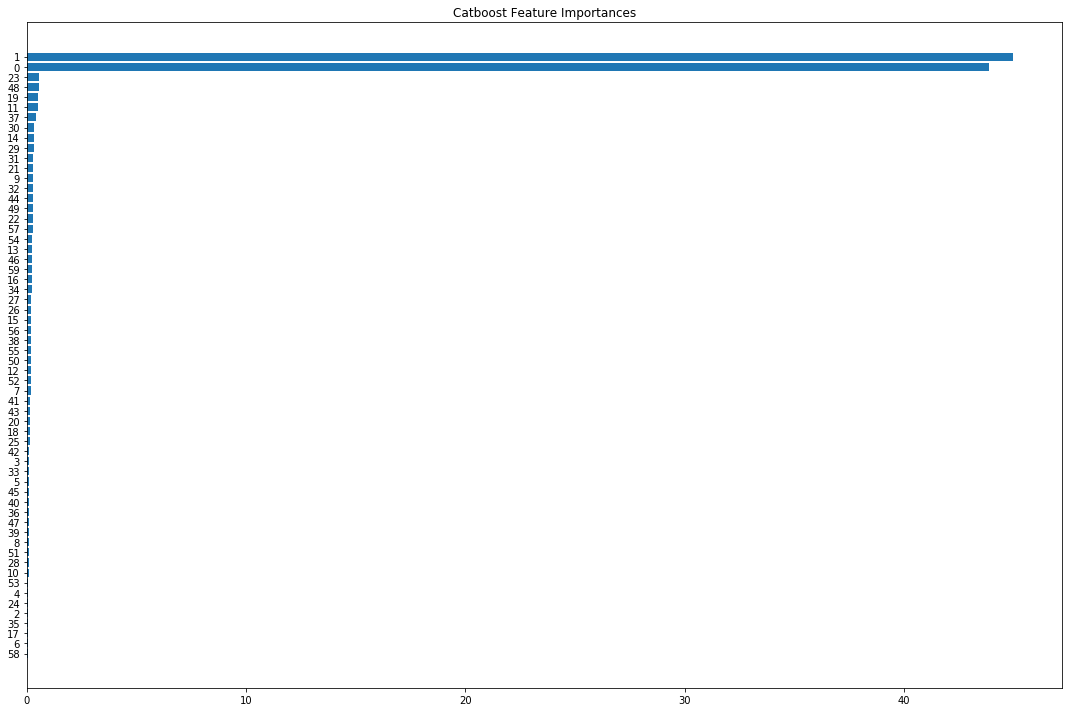

In [61]:
tree_feature_importances = (cat.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Catboost Feature Importances")
fig.tight_layout()
plt.savefig('Catboost PCA Feature Importances')
plt.show()

In [ ]:
# feature_importances = pd.DataFrame(rf.feature_importances_,
#                                    index = data_pca.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)

In [48]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA, random_state=100).fit(train_features)
X_pc = model.transform(train_features)

#features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [49]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA, FIRST_N_FFT
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    component_max_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).max() for i in range(N_COMPONENTS_PCA)]
    component_mean_list = [abs(pd.DataFrame(model_pca.components_).loc[i, :]).mean() for i in range(N_COMPONENTS_PCA)]
        
    for feature in tqdm(range(0, size[0]*FIRST_N_FFT)):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value =abs( model_pca.components_[component, feature])
            component_max = component_max_list[component]
            component_mean = component_mean_list[component]
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [50]:
d = features_imp_pca((train_features), model, X_pc, features_good, features_bad, features_normal)

100%|██████████| 22272/22272 [00:03<00:00, 7259.68it/s]


In [51]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(15)]

In [52]:
sorted_d[:15]

[('feature_9180', 120),
 ('feature_2560', 65),
 ('feature_2675', 60),
 ('feature_2656', 50),
 ('feature_0', 39),
 ('feature_30', 39),
 ('feature_2595', 39),
 ('feature_2588', 34),
 ('feature_48', 30),
 ('feature_2561', 30),
 ('feature_9088', 30),
 ('feature_9099', 30),
 ('feature_1', 29),
 ('feature_20307', 28),
 ('feature_2652', 25)]

In [53]:
sorted_d[-15:]

[('feature_55', -16),
 ('feature_32', -18),
 ('feature_12', -22),
 ('feature_43', -22),
 ('feature_21', -24),
 ('feature_25', -24),
 ('feature_52', -24),
 ('feature_36', -26),
 ('feature_46', -26),
 ('feature_50', -28),
 ('feature_27', -30),
 ('feature_16', -36),
 ('feature_39', -38),
 ('feature_4', -40),
 ('feature_15', -42)]

In [54]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [55]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in tqdm(range(train_features.shape[0])):
    sample = pd.DataFrame(np.zeros((CHANALS, 174)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = CHANALS

        
    for s in range(174): ##!!!
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += CHANALS

        if index_end > size[0]*174:
            break

    old_table.append(sample.values)
  

100%|██████████| 192/192 [00:31<00:00,  6.20it/s]


In [56]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            
            

192it [00:04, 41.47it/s]


In [57]:
FE_items

[(0, 0, 0),
 (0, 1, 0),
 (0, 30, 0),
 (0, 48, 0),
 (0, 0, 20),
 (0, 1, 20),
 (0, 28, 20),
 (0, 35, 20),
 (0, 92, 20),
 (0, 96, 20),
 (0, 115, 20),
 (0, 0, 71),
 (0, 11, 71),
 (0, 92, 71),
 (0, 83, 158),
 (1, 0, 0),
 (1, 1, 0),
 (1, 30, 0),
 (1, 48, 0),
 (1, 0, 20),
 (1, 1, 20),
 (1, 28, 20),
 (1, 35, 20),
 (1, 92, 20),
 (1, 96, 20),
 (1, 115, 20),
 (1, 0, 71),
 (1, 11, 71),
 (1, 92, 71),
 (1, 83, 158),
 (2, 0, 0),
 (2, 1, 0),
 (2, 30, 0),
 (2, 48, 0),
 (2, 0, 20),
 (2, 1, 20),
 (2, 28, 20),
 (2, 35, 20),
 (2, 92, 20),
 (2, 96, 20),
 (2, 115, 20),
 (2, 0, 71),
 (2, 11, 71),
 (2, 92, 71),
 (2, 83, 158),
 (3, 0, 0),
 (3, 1, 0),
 (3, 30, 0),
 (3, 48, 0),
 (3, 0, 20),
 (3, 1, 20),
 (3, 28, 20),
 (3, 35, 20),
 (3, 92, 20),
 (3, 96, 20),
 (3, 115, 20),
 (3, 0, 71),
 (3, 11, 71),
 (3, 92, 71),
 (3, 83, 158),
 (4, 0, 0),
 (4, 1, 0),
 (4, 30, 0),
 (4, 48, 0),
 (4, 0, 20),
 (4, 1, 20),
 (4, 28, 20),
 (4, 35, 20),
 (4, 92, 20),
 (4, 96, 20),
 (4, 115, 20),
 (4, 0, 71),
 (4, 11, 71),
 (4, 92, 71),


In [58]:
best_feat = list(map(lambda x: x[0], 
    sorted(collections.Counter(list(map(lambda x: x[1], FE_items))).items(), 
           key=operator.itemgetter(1), reverse=True)))

____

In [59]:
for i in best_feat:
    print(np.argmax(np.abs(FastICA.mixing_[:, i])))

65
10
10
65
100
100
65
10
10
10
65


In [60]:
FastICA.mixing_.shape

(128, 128)